<a href="https://colab.research.google.com/github/peeyushsinghal/da/blob/main/mitigating_bias_sa_da_v32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes : 


* LR Scheduler on Training Loss


# Mitigating bias in sentiment analysis using domain adaptation

In [1]:
! pip install torchtext==0.10.0 --quiet # DOWNGRADE YOUR TORCHTEXT
! pip install ekphrasis --quiet # library to pre process twitter data
! pip install emoji --upgrade --quiet #library to deal with emoji data
# ! pip install torch-lr-finder # library to find LR 

In [2]:
## Import statements
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.legacy.data import Dataset, Field, TabularDataset, BucketIterator
from torchtext.vocab import GloVe
import torchtext.vocab as vocab
import numpy as np
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import emoji
from torchtext.legacy.vocab import Vectors
from tqdm import tqdm
import random
import torch.optim as optim
import scipy.stats as stats
from statistics import mean

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
en_stops = set(stopwords.words('english'))

import time

from copy import deepcopy

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


import matplotlib.pyplot as plt
# import EarlyStopping
# from pytorchtools import EarlyStopping

# from torch_lr_finder import LRFinder


from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# checking device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:{}".format(DEVICE))

Running on:cuda


## Data loading

In [4]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data Configuration

In [5]:

BASE_PATH = '/content/drive/MyDrive/semeval-2018'

DATA_DIR = os.path.join(BASE_PATH,'datasets')
TARGET_DIR = os.path.join(BASE_PATH,'targetdataset')

MODEL_DIR = os.path.join(BASE_PATH,'models')
REF_DIR = os.path.join(BASE_PATH,'reference')
EMBEDDINGS_DIR = os.path.join(BASE_PATH,'embeddings')

MAX_SIZE = 50
MAX_VOCAB_SIZE = 10000

# BATCH_SIZE = 8
# BATCH_SIZE = 32
BATCH_SIZE = 16 # based on EWC paper

EMBEDDING_TO_BE_USED = 'glove_gn' # {'glove', 'glove_gn'}
TARGET_BATCH_SIZE = 8

# NUM_EPOCHS = 100
# NUM_EPOCHS = 2
# NUM_EPOCHS = 30

NUM_EPOCHS = 150
INITIAL_LR = 0.02 
# INITIAL_LR = 0.1
dict_initial_lr = {'EI_sadness': 0.005,
                   'V' : 0.02,
                   'EI_fear': 0.02,
                   'EI_anger' : 0.05,
                   'EI_joy': 0.05  }


DANN_NUM_EPOCHS = 50
DANN_INITIAL_LR = 0.001

DANN_EWC_NUM_EPOCHS = 50
DANN_EWC_INITIAL_LR = 0.0001
# INITIAL_LR_EWC = INITIAL_LR / NUM_EPOCHS
LR_GAMMA = 0.9
LR = 2e-4

from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau,ExponentialLR

PATIENCE = 15
EWC_LAMBDA = 0.4

if not os.path.exists(MODEL_DIR):
  os.makedirs(MODEL_DIR)
  print("The new directory is created!")


BONFERRONI_CORRECTION = 5.0

In [6]:
# Seed and Cuda

# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED) 
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

 Cuda Status : True


In [7]:
# data configuration

class TASK1(object):
  
    EI_reg = {
        'anger': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-anger-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-anger-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-anger-test-gold.txt')
                },
        'joy': {
                'train': os.path.join(
                    DATA_DIR, 'task1/EI-reg/training/EI-reg-En-joy-train.txt'),
                'dev': os.path.join(
                    DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-joy-dev.txt'),
                'gold': os.path.join(
                    DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-joy-test-gold.txt')
                },
        'fear': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-fear-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-fear-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-fear-test-gold.txt')
                },
        'sadness': {
            'train': os.path.join(
                DATA_DIR, 'task1/EI-reg/training/EI-reg-En-sadness-train.txt'),
            'dev': os.path.join(
                DATA_DIR, 'task1/EI-reg/development/2018-EI-reg-En-sadness-dev.txt'),
            'gold': os.path.join(
                DATA_DIR, 'task1/EI-reg/test-gold/2018-EI-reg-En-sadness-test-gold.txt')
                }                     
        }

    V_reg = {
        'train': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-train.txt'),
        'dev': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-dev.txt'),
        'gold': os.path.join(
            DATA_DIR, 'task1/V-reg/2018-Valence-reg-En-test-gold.txt')
             }

    EEC = {
        'eec': os.path.join(
            DATA_DIR, 'task1/Equity-Evaluation-Corpus/Equity-Evaluation-Corpus.csv')
             }

## Source Data
Parsing Emotion and Valence regression data : `format [ID	Tweet	Affect Dimension	Intensity Score]`

In [8]:
def parse_reg(data_file, label_format='tuple'):
    """
    This is for datasets for the EI-reg and V-reg English tasks 
    Returns:
        df: dataframe with columns in the first row of file [ID-Tweet-Affect Dimension-Intensity Score]
    """
    with open(data_file, 'r') as fd:
      data = [l.strip().split('\t') for l in fd.readlines()]
    # print(data)
    df = pd.DataFrame (data[1:],columns=data[0])
    csv_file_name = (data_file.split("/")[-1]).split('.')[0]+".csv"
    csv_file = df.to_csv(str(csv_file_name))
    return csv_file_name


Generic Source Data Parser

In [9]:
def parse_csv(task, dataset, emotion='anger'):
    if task == 'EI-reg':
        data_train = TASK1.EI_reg[emotion][dataset]
        csv_file_name = parse_reg(data_train)
        return csv_file_name

    elif task == 'V-reg':
        data_train = TASK1.V_reg[dataset]

        csv_file_name = parse_reg(data_train)
        return csv_file_name

    else:
        return None

In [10]:
emotions = ['anger','joy','fear','sadness']
dict_data ={'train':'train','dev':'val','gold':'test'}
dict_file_name ={}
for emotion in emotions:
  for data_info, data_usage in dict_data.items():
    file_name = str('file_EI_'+ emotion + "_" + data_usage)
    dict_file_name[file_name] = parse_csv('EI-reg', data_info, emotion)

    file_name2 = str('file_V_'+ data_usage)
    dict_file_name[file_name2] = parse_csv('V-reg', data_info)

(dict_file_name)

{'file_EI_anger_train': 'EI-reg-En-anger-train.csv',
 'file_V_train': '2018-Valence-reg-En-train.csv',
 'file_EI_anger_val': '2018-EI-reg-En-anger-dev.csv',
 'file_V_val': '2018-Valence-reg-En-dev.csv',
 'file_EI_anger_test': '2018-EI-reg-En-anger-test-gold.csv',
 'file_V_test': '2018-Valence-reg-En-test-gold.csv',
 'file_EI_joy_train': 'EI-reg-En-joy-train.csv',
 'file_EI_joy_val': '2018-EI-reg-En-joy-dev.csv',
 'file_EI_joy_test': '2018-EI-reg-En-joy-test-gold.csv',
 'file_EI_fear_train': 'EI-reg-En-fear-train.csv',
 'file_EI_fear_val': '2018-EI-reg-En-fear-dev.csv',
 'file_EI_fear_test': '2018-EI-reg-En-fear-test-gold.csv',
 'file_EI_sadness_train': 'EI-reg-En-sadness-train.csv',
 'file_EI_sadness_val': '2018-EI-reg-En-sadness-dev.csv',
 'file_EI_sadness_test': '2018-EI-reg-En-sadness-test-gold.csv'}

## Preprocess tweets

In [11]:
# reference : https://github.com/cbaziotis/ekphrasis


text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

/usr/local/lib/python3.8/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


/usr/local/lib/python3.8/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [12]:
def preprocess_tweet(tweet): 
  tweet_processed = text_processor.pre_process_doc(tweet)
  # print (tweet_processed)
  demojized_list =[]
  final_list =[]
  for index, tweet in enumerate(tweet_processed):
      demojized_list.append(emoji.demojize(tweet, language = 'en'))
  final_list = [w for w in demojized_list if w not in en_stops] 
  
  # print(df)
  return final_list

## TorchText Treatment

In [13]:
# dict_file_name.keys()

In [14]:
dict_fields ={}
list_name = list(set(["_".join(key.split("_")[1:-1]) for key in list(dict_file_name.keys())]))


for name in list_name:
  field_tweet = Field(sequential=True, 
                      use_vocab = True, 
                      tokenize = preprocess_tweet, 
                      fix_length = MAX_SIZE, 
                      batch_first = True)
  field_intensity = Field(sequential= False, 
                        dtype = torch.float,
                        use_vocab = False)
  fields = {
    'Tweet':('tweet', field_tweet ), #
    'Intensity Score': ('intensity',field_intensity) # Intensity Score is name of the dataset column, field_intensity is how we have defined the field, intensity is the name of the variable going fwd
    }
  
  dict_fields[name] = fields

# dict_fields

In [15]:
dict_dataset ={}
for file_key, file_name in dict_file_name.items():
  # print(file_key,file_name)
  if "train" in (file_key.split("_")[-1]):
    head_name = "_".join(file_key.split("_")[0:-1])
    base_name = "_".join(file_key.split("_")[1:-1])
    # print(base_name)
    train_file = dict_file_name[head_name+"_train"]
    val_file = dict_file_name[head_name+"_val"]
    test_file =  dict_file_name[head_name+"_test"]

    train, val, test =TabularDataset.splits( path = './', 
                                            train = train_file, 
                                            validation = val_file, 
                                            test = test_file,
                                            format = 'csv', 
                                            fields = dict_fields[base_name])
    
  
    dict_dataset[base_name] = {"train_dataset": train, "val_dataset":val,"test_dataset":test}

In [16]:
for key, value in dict_dataset.items():
  # count = 0
  for name, dataset in value.items():
    for example in dataset.examples:
      print(key, name, example.tweet, example.intensity)
      break

EI_anger train_dataset ['<user>', '<user>', 'shut', 'hashtags', 'cool', '<hashtag>', 'offended', '</hashtag>'] 0.562
EI_anger val_dataset ["'", 'need', 'something', '.', 'something', 'must', 'done', '!', '<repeated>', "'", '\\', 'n', '\\', 'nyour', 'anxiety', 'amusing', '.', 'nothing', 'done', '.', 'despair', '.'] 0.517
EI_anger test_dataset ['<user>', 'know', 'mean', 'well', 'offended', '.', 'prick', '.'] 0.734
V train_dataset ['<user>', 'yeah', '!', '<happy>', 'playing', 'well'] 0.600
V val_dataset ['<user>', 'site', 'crashes', 'everytime', 'try', 'book', '-', 'help', '?', 'tell', "'", 'nothing', 'wrong', '&', 'hang', '<hashtag>', 'furious', '</hashtag>', '<hashtag>', 'helpless', '</hashtag>', '<user>'] 0.141
V test_dataset ['gm', '<hashtag>', 'tuesday', '</hashtag>', '!'] 0.589
EI_joy train_dataset ['<user>', 'quite', 'saddened', '.', '<repeated>', 'us', 'dates', ',', 'joyous', 'anticipation', 'attending', 'dg', 'concert', '(', 'since', '<number>', ')', '.', 'happy', 'keeping', 'bus

## Building iterator and Vocabulary

In [17]:
for name, value in dict_fields.items():
  print(name, value)

EI_joy {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7f2c9eb44ca0>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7f2c9eb44f40>)}
EI_sadness {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7f2c9eb44e80>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7f2c9eb44ee0>)}
V {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7f2c9eb44f10>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7f2c9eb44f70>)}
EI_anger {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7f2c9eb44fa0>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7f2c9eb44520>)}
EI_fear {'Tweet': ('tweet', <torchtext.legacy.data.field.Field object at 0x7f2c9eb44fd0>), 'Intensity Score': ('intensity', <torchtext.legacy.data.field.Field object at 0x7f2c9eb444f0>)}


In [18]:
dict_emb_file = {'glove':'glove.6B.300d.txt',
                 'glove_gn': '1b-vectors300-0.8-0.8.txt'}

print("EMBEDDING_TO_BE_USED:", EMBEDDING_TO_BE_USED)
emb_file_path = os.path.join(EMBEDDINGS_DIR ,dict_emb_file[EMBEDDING_TO_BE_USED])
emb_file_path

EMBEDDING_TO_BE_USED: glove_gn


'/content/drive/MyDrive/semeval-2018/embeddings/1b-vectors300-0.8-0.8.txt'

In [19]:

for name, value in dict_fields.items():
  # print(name, value['Tweet'][1])
  
  ## start for embeddings from text file
  value['Tweet'][1].build_vocab(dict_dataset[name]['train_dataset'])
  vectors = vocab.Vectors(emb_file_path) # location of embeddings file, full path
  value['Tweet'][1].vocab.set_vectors(vectors.stoi, vectors.vectors, vectors.dim)
  ## end for embeddings from text file

  value['Intensity Score'][1].build_vocab(dict_dataset[name]['train_dataset'])


In [20]:
dict_iterator ={}
for name, value in dict_dataset.items():
  VALID_BATCH_SIZE = len(value['val_dataset']) - 1
  TEST_BATCH_SIZE = len(value['test_dataset'])  -1
  # VALID_TEST_BATCH_SIZE= min(len(value['val_dataset']),len(value['test_dataset']) )
  print(name, VALID_BATCH_SIZE , TEST_BATCH_SIZE)
  train_iterator, val_iterator, test_iterator= BucketIterator.splits(
      (value['train_dataset'], value['val_dataset'],value['test_dataset']),
      batch_sizes= (BATCH_SIZE,VALID_BATCH_SIZE, TEST_BATCH_SIZE),
      sort_key = lambda x: len(x.tweet),
      sort_within_batch=True,
      device = DEVICE,
      shuffle= True)
  
  dict_iterator[name] = {"train_iterator": train_iterator, "val_iterator":val_iterator,"test_iterator":test_iterator}


EI_anger 387 1001
V 448 936
EI_joy 289 1104
EI_fear 388 985
EI_sadness 396 974


In [21]:
# dict_iterator.items()

In [22]:
# for key, value in dict_iterator.items():
#   for name, iterator in value.items():
#     for batch in iterator:
#       print(key, name, batch.tweet)
#       print(batch.intensity)
#       break
#     break
#   break


In [23]:
for name in list_name:
  print(dict_fields[name]['Tweet'][1].vocab.stoi.items())

dict_items([('<unk>', 0), ('<pad>', 1), ('</hashtag>', 2), ('<hashtag>', 3), ('.', 4), ('<user>', 5), (',', 6), ("'", 7), ('!', 8), ('<repeated>', 9), ('\\', 10), ('<number>', 11), ('happy', 12), ('-', 13), ('n', 14), ('</allcaps>', 15), ('<allcaps>', 16), ('day', 17), ('love', 18), ('&', 19), ('?', 20), ('smile', 21), (':', 22), ('good', 23), ('hilarious', 24), ('like', 25), ('watch', 26), ('optimism', 27), ('live', 28), ('amazing', 29), ('laughter', 30), ('make', 31), ('lively', 32), ('life', 33), ('time', 34), ('glee', 35), ('one', 36), ('get', 37), ('musically', 38), ('broadcast', 39), ('ly', 40), ('see', 41), ('/', 42), ('know', 43), ('go', 44), ('smiling', 45), ('always', 46), ('cheer', 47), ('much', 48), (':face_with_tears_of_joy:', 49), ('new', 50), ('u', 51), ('today', 52), ('us', 53), ('people', 54), ('want', 55), ('feel', 56), ('got', 57), ('<happy>', 58), ('joyful', 59), ('breezy', 60), ('delight', 61), ('rejoice', 62), ('great', 63), ('cheerful', 64), ('pleasing', 65), ('s

## TorchText treatment of Target Data

In [24]:
# Target Data
df_target = pd.read_csv(os.path.join(TARGET_DIR,'winomt_saunders_combined.csv'))
print(df_target.head())
target_file_name = 'target_csv.csv'
target_csv_file = df_target.to_csv(str(target_file_name))

                             Tweet  Intensity Score
0    the actor finished her work .                0
1    the actor finished his work .                0
2  the actuary finished her work .                0
3  the actuary finished his work .                0
4    the agent finished her work .                0


In [25]:
dict_target_dataset = {}
for name in list_name:
  # print(dict_fields[name])
  dict_target_dataset [name] = TabularDataset( path = os.path.join(TARGET_DIR,'winomt_saunders_combined.csv'), 
                                              format = 'csv',
                                              fields = dict_fields[name] )

print(dict_target_dataset)

{'EI_joy': <torchtext.legacy.data.dataset.TabularDataset object at 0x7f2ca6cfa940>, 'EI_sadness': <torchtext.legacy.data.dataset.TabularDataset object at 0x7f2ca6cfa370>, 'V': <torchtext.legacy.data.dataset.TabularDataset object at 0x7f2ca6cb90d0>, 'EI_anger': <torchtext.legacy.data.dataset.TabularDataset object at 0x7f2c6f6f9970>, 'EI_fear': <torchtext.legacy.data.dataset.TabularDataset object at 0x7f2c6f6f96d0>}


In [26]:
for name, dataset in dict_target_dataset.items():
  count=0
  for example in dataset:
    print(example.tweet, example.intensity)
    count += 1
    if count > 2:
      break

['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actor', 'finished', 'work', '.'] 0
['actuary', 'finished', 'work', '.'] 0


In [27]:
dict_target_iterator = {}
for name in list_name:
  dict_target_iterator [name] = BucketIterator(dict_target_dataset[name], # given that there is only one dataset we are not using splits
                                 batch_size= TARGET_BATCH_SIZE,
                                 sort_key = lambda x: len(x.tweet),
                                 sort_within_batch=True,
                                 device = DEVICE,
                                 repeat=True,
                                 shuffle= True)

# print(dict_target_iterator)

In [28]:
# next(iter(target_iterator))

In [29]:
# for name, iterator in dict_target_iterator.items():
#   count = 0
#   for batch in iterator:
#     print(name)
#     print(batch)
#     print (batch.tweet)
#     print (batch.intensity)
#     count += 1
#     break
#     if count > 2:
#       break

## CNN 1d model

### Gradient Reversal layer

In [30]:
from torch.autograd import Function


class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

CNN 1 D model
Reference: A Sensitivity Analysis of (and Practitioners' Guide to) Convolutional Neural Networks for Sentence Classification, Ye Zhang, Byron Wallace 2015

Difference:

use of embedding
use of sigmoid function, as we are having a regression model not a classififer as the main task

In [31]:
import torch.nn as nn
import torch.nn.functional as F

class CNN1d(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 n_filters, 
                 filter_sizes, 
                 output_dim, 
                 dropout, 
                 pad_idx
                 ):
        super().__init__()
        
        #---------------------Feature Extractor Network----------------------#
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        # Convolutional Network
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])
        
        #---------------------Regression Network------------------------#
        # Fully-connected layer and Dropout
        self.regression = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(len(filter_sizes) * n_filters, len(filter_sizes) * n_filters // 2),
            nn.ReLU(),
            nn.Linear(len(filter_sizes) * n_filters // 2, output_dim * 10),
            nn.ReLU(),
            nn.Linear(output_dim * 10, output_dim)
            # ,
            # nn.Sigmoid()
        )
        # self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim * 10)
        # self.fc2 = nn.Linear(output_dim * 10, output_dim)
        # self.dropout = nn.Dropout(dropout)

        #---------------------Domain Classifier Network------------------------#
        # Fully-connected layer and Dropout
        self.domain_classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(len(filter_sizes) * n_filters, len(filter_sizes) * n_filters // 2),
            nn.ReLU(),
            nn.Linear(len(filter_sizes) * n_filters // 2, output_dim * 10),
            nn.ReLU(),
            nn.Linear(output_dim * 10, 2),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, text, alpha=1.0):
        
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.permute(0, 2, 1)
        
        #embedded = [batch size, emb dim, sent len]
        
        conved = [F.relu(conv(embedded)) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        x_feature = torch.cat(pooled, dim = 1)
        
        #x_feature = [batch size, n_filters * len(filter_sizes)]
        
        reverse_feature = GradientReversalFn.apply(x_feature, alpha)
        # print("reverse_feature",reverse_feature)
    
        regression_output = self.regression(x_feature)
    
        domain_classifier_output = self.domain_classifier(reverse_feature)


        return regression_output, domain_classifier_output

In [32]:
# INPUT_DIM = len(field_tweet.vocab) # these change for each model
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2, 3, 4, 5]
OUTPUT_DIM = 1
DROPOUT = 0.5
# PAD_IDX = field_tweet.vocab.stoi[field_tweet.pad_token] # these change for each model

### Model Architecture Creation for each variant, Loading pre-trained embeddings

In [33]:
dict_model_arch ={}
for name in list_name:
  
  # INPUT_DIM = len(field_tweet.vocab) # single model
  INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
  # print(INPUT_DIM)

  # PAD_IDX = field_tweet.vocab.stoi[field_tweet.pad_token] # # single model
  PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]
  # print(PAD_IDX)

  dict_model_arch[name] = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  dict_model_arch[name].to(DEVICE)

  # pretrained_embeddings = field_tweet.vocab.vectors # single model
  pretrained_embeddings = dict_fields[name]['Tweet'][1].vocab.vectors

  # model.embedding.weight.data.copy_(pretrained_embeddings) # single model
  # dict_model_arch[name].embedding.weight.data.copy_(pretrained_embeddings)

  ## start for embeddings from text file
  dict_model_arch[name].embedding.from_pretrained(torch.FloatTensor(dict_fields[name]['Tweet'][1].vocab.vectors))
  ## end for embeddings from text file

  # UNK_IDX = field_tweet.vocab.stoi[field_tweet.unk_token] # single model
  UNK_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].unk_token]

  # model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM) # single model
  dict_model_arch[name].embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM) 
  
  # model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM) # single model
  dict_model_arch[name].embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM) 

dict_model_arch

{'EI_joy': CNN1d(
   (embedding): Embedding(4653, 100, padding_idx=1)
   (convs): ModuleList(
     (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
     (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
     (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
     (3): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
   )
   (regression): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=400, out_features=200, bias=True)
     (2): ReLU()
     (3): Linear(in_features=200, out_features=10, bias=True)
     (4): ReLU()
     (5): Linear(in_features=10, out_features=1, bias=True)
   )
   (domain_classifier): Sequential(
     (0): Dropout(p=0.5, inplace=False)
     (1): Linear(in_features=400, out_features=200, bias=True)
     (2): ReLU()
     (3): Linear(in_features=200, out_features=10, bias=True)
     (4): ReLU()
     (5): Linear(in_features=10, out_features=2, bias=True)
     (6): LogSoftmax(dim=1)
   )
 ), 'EI_sadness': CNN1d(
   (embedding): Embeddi

In [34]:
# model = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
# model.to(DEVICE)

## Learning Rate

### LR Class

In [35]:
# # 
# """
# Reference: https://github.com/davidtvs/pytorch-lr-finder

# """

# from __future__ import print_function, with_statement, division
# import copy
# import os
# import torch
# from tqdm.autonotebook import tqdm
# from torch.optim.lr_scheduler import _LRScheduler
# import matplotlib.pyplot as plt

# try:
#     from apex import amp

#     IS_AMP_AVAILABLE = True
# except ImportError:
#     import logging

#     logging.basicConfig()
#     logger = logging.getLogger(__name__)
#     logger.warning(
#         "To enable mixed precision training, please install `apex`. "
#         "Or you can re-install this package by the following command:\n"
#         '  pip install torch-lr-finder -v --global-option="amp"'
#     )
#     IS_AMP_AVAILABLE = False
#     del logging


# class LRFinder(object):
#     """Learning rate range test.
#     The learning rate range test increases the learning rate in a pre-training run
#     between two boundaries in a linear or exponential manner. It provides valuable
#     information on how well the network can be trained over a range of learning rates
#     and what is the optimal learning rate.
#     Arguments:
#         model (torch.nn.Module): wrapped model.
#         optimizer (torch.optim.Optimizer): wrapped optimizer where the defined learning
#             is assumed to be the lower boundary of the range test.
#         criterion (torch.nn.Module): wrapped loss function.
#         device (str or torch.device, optional): a string ("cpu" or "cuda") with an
#             optional ordinal for the device type (e.g. "cuda:X", where is the ordinal).
#             Alternatively, can be an object representing the device on which the
#             computation will take place. Default: None, uses the same device as `model`.
#         memory_cache (boolean, optional): if this flag is set to True, `state_dict` of
#             model and optimizer will be cached in memory. Otherwise, they will be saved
#             to files under the `cache_dir`.
#         cache_dir (string, optional): path for storing temporary files. If no path is
#             specified, system-wide temporary directory is used. Notice that this
#             parameter will be ignored if `memory_cache` is True.
#     Example:
#         >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
#         >>> lr_finder.range_test(dataloader, end_lr=100, num_iter=100)
#         >>> lr_finder.plot() # to inspect the loss-learning rate graph
#         >>> lr_finder.reset() # to reset the model and optimizer to their initial state
#     Reference:
#     Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
#     fastai/lr_find: https://github.com/fastai/fastai
#     """

#     def __init__(
#         self,
#         model,
#         optimizer,
#         criterion,
#         device=None,
#         memory_cache=True,
#         cache_dir=None,
#     ):
#         # Check if the optimizer is already attached to a scheduler
#         self.optimizer = optimizer
#         self._check_for_scheduler()

#         self.model = model
#         self.criterion = criterion
#         self.history = {"lr": [], "loss": []}
#         self.best_loss = None
#         self.memory_cache = memory_cache
#         self.cache_dir = cache_dir

#         # Save the original state of the model and optimizer so they can be restored if
#         # needed
#         self.model_device = next(self.model.parameters()).device
#         self.state_cacher = StateCacher(memory_cache, cache_dir=cache_dir)
#         self.state_cacher.store("model", self.model.state_dict())
#         self.state_cacher.store("optimizer", self.optimizer.state_dict())

#         # If device is None, use the same as the model
#         if device:
#             self.device = device
#         else:
#             self.device = self.model_device

#     def reset(self):
#         """Restores the model and optimizer to their initial states."""

#         self.model.load_state_dict(self.state_cacher.retrieve("model"))
#         self.optimizer.load_state_dict(self.state_cacher.retrieve("optimizer"))
#         self.model.to(self.model_device)

#     def range_test(
#         self,
#         train_loader,
#         val_loader=None,
#         start_lr=None,
#         end_lr=10,
#         num_iter=100,
#         step_mode="exp",
#         smooth_f=0.05,
#         diverge_th=5,
#         accumulation_steps=1,
#     ):
#         """Performs the learning rate range test.
#         Arguments:
#             train_loader (torch.utils.data.DataLoader): the training set data laoder.
#             val_loader (torch.utils.data.DataLoader, optional): if `None` the range test
#                 will only use the training loss. When given a data loader, the model is
#                 evaluated after each iteration on that dataset and the evaluation loss
#                 is used. Note that in this mode the test takes significantly longer but
#                 generally produces more precise results. Default: None.
#             start_lr (float, optional): the starting learning rate for the range test.
#                 Default: None (uses the learning rate from the optimizer).
#             end_lr (float, optional): the maximum learning rate to test. Default: 10.
#             num_iter (int, optional): the number of iterations over which the test
#                 occurs. Default: 100.
#             step_mode (str, optional): one of the available learning rate policies,
#                 linear or exponential ("linear", "exp"). Default: "exp".
#             smooth_f (float, optional): the loss smoothing factor within the [0, 1[
#                 interval. Disabled if set to 0, otherwise the loss is smoothed using
#                 exponential smoothing. Default: 0.05.
#             diverge_th (int, optional): the test is stopped when the loss surpasses the
#                 threshold:  diverge_th * best_loss. Default: 5.
#             accumulation_steps (int, optional): steps for gradient accumulation. If it
#                 is 1, gradients are not accumulated. Default: 1.
#         Example (fastai approach):
#             >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
#             >>> lr_finder.range_test(dataloader, end_lr=100, num_iter=100)
#         Example (Leslie Smith's approach):
#             >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
#             >>> lr_finder.range_test(trainloader, val_loader=val_loader, end_lr=1, num_iter=100, step_mode="linear")
#         Gradient accumulation is supported; example:
#             >>> train_data = ...    # prepared dataset
#             >>> desired_bs, real_bs = 32, 4         # batch size
#             >>> accumulation_steps = desired_bs // real_bs     # required steps for accumulation
#             >>> dataloader = torch.utils.data.DataLoader(train_data, batch_size=real_bs, shuffle=True)
#             >>> acc_lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
#             >>> acc_lr_finder.range_test(dataloader, end_lr=10, num_iter=100, accumulation_steps=accumulation_steps)
#         Reference:
#         [Training Neural Nets on Larger Batches: Practical Tips for 1-GPU, Multi-GPU & Distributed setups](
#         https://medium.com/huggingface/ec88c3e51255)
#         [thomwolf/gradient_accumulation](https://gist.github.com/thomwolf/ac7a7da6b1888c2eeac8ac8b9b05d3d3)
#         """

#         # Reset test results
#         self.history = {"lr": [], "loss": []}
#         self.best_loss = None

#         # Move the model to the proper device
#         self.model.to(self.device)

#         # Check if the optimizer is already attached to a scheduler
#         self._check_for_scheduler()

#         # Set the starting learning rate
#         if start_lr:
#             self._set_learning_rate(start_lr)

#         # Initialize the proper learning rate policy
#         if step_mode.lower() == "exp":
#             lr_schedule = ExponentialLR(self.optimizer, end_lr, num_iter)
#         elif step_mode.lower() == "linear":
#             lr_schedule = LinearLR(self.optimizer, end_lr, num_iter)
#         else:
#             raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

#         if smooth_f < 0 or smooth_f >= 1:
#             raise ValueError("smooth_f is outside the range [0, 1[")

#         # Create an iterator to get data batch by batch
#         iter_wrapper = DataLoaderIterWrapper(train_loader)
#         for iteration in tqdm(range(num_iter)):
#             # Train on batch and retrieve loss
#             loss = self._train_batch(iter_wrapper, accumulation_steps)
#             if val_loader:
#                 loss = self._validate(val_loader)

#             # Update the learning rate
#             lr_schedule.step()
#             self.history["lr"].append(lr_schedule.get_lr()[0])

#             # Track the best loss and smooth it if smooth_f is specified
#             if iteration == 0:
#                 self.best_loss = loss
#             else:
#                 if smooth_f > 0:
#                     loss = smooth_f * loss + (1 - smooth_f) * self.history["loss"][-1]
#                 if loss < self.best_loss:
#                     self.best_loss = loss

#             # Check if the loss has diverged; if it has, stop the test
#             self.history["loss"].append(loss)
#             if loss > diverge_th * self.best_loss:
#                 print("Stopping early, the loss has diverged")
#                 break

#         print("Learning rate search finished. See the graph with {finder_name}.plot()")

#     def _set_learning_rate(self, new_lrs):
#         if not isinstance(new_lrs, list):
#             new_lrs = [new_lrs] * len(self.optimizer.param_groups)
#         if len(new_lrs) != len(self.optimizer.param_groups):
#             raise ValueError(
#                 "Length of `new_lrs` is not equal to the number of parameter groups "
#                 + "in the given optimizer"
#             )

#         for param_group, new_lr in zip(self.optimizer.param_groups, new_lrs):
#             param_group["lr"] = new_lr

#     def _check_for_scheduler(self):
#         for param_group in self.optimizer.param_groups:
#             if "initial_lr" in param_group:
#                 raise RuntimeError("Optimizer already has a scheduler attached to it")

#     def _train_batch(self, iter_wrapper, accumulation_steps):
#         self.model.train()
#         total_loss = None  # for late initialization

#         self.optimizer.zero_grad()
#         for i in range(accumulation_steps):
#             inputs, labels = iter_wrapper.get_batch()
#             inputs, labels = self._move_to_device(inputs, labels)

#             # Forward pass
#             outputs = self.model(inputs)
#             loss = self.criterion(outputs, labels)

#             # Loss should be averaged in each step
#             loss /= accumulation_steps

#             # Backward pass
#             if IS_AMP_AVAILABLE and hasattr(self.optimizer, "_amp_stash"):
#                 # For minor performance optimization, see also:
#                 # https://nvidia.github.io/apex/advanced.html#gradient-accumulation-across-iterations
#                 delay_unscale = ((i + 1) % accumulation_steps) != 0

#                 with amp.scale_loss(
#                     loss, self.optimizer, delay_unscale=delay_unscale
#                 ) as scaled_loss:
#                     scaled_loss.backward()
#             else:
#                 loss.backward()

#             if total_loss is None:
#                 total_loss = loss
#             else:
#                 total_loss += loss

#         self.optimizer.step()

#         return total_loss.item()

#     def _move_to_device(self, inputs, labels):
#         def move(obj, device):
#             if isinstance(obj, tuple):
#                 return tuple(move(o, device) for o in obj)
#             elif torch.is_tensor(obj):
#                 return obj.to(device)
#             elif isinstance(obj, list):
#                 return [move(o, device) for o in obj]
#             else:
#                 return obj

#         inputs = move(inputs, self.device)
#         labels = move(labels, self.device)
#         return inputs, labels

#     def _validate(self, dataloader):
#         # Set model to evaluation mode and disable gradient computation
#         running_loss = 0
#         self.model.eval()
#         with torch.no_grad():
#             for inputs, labels in dataloader:
#                 # Move data to the correct device
#                 inputs, labels = self._move_to_device(inputs, labels)

#                 if isinstance(inputs, tuple) or isinstance(inputs, list):
#                     batch_size = inputs[0].size(0)
#                 else:
#                     batch_size = inputs.size(0)

#                 # Forward pass and loss computation
#                 outputs = self.model(inputs)
#                 loss = self.criterion(outputs, labels)
#                 running_loss += loss.item() * batch_size

#         return running_loss / len(dataloader.dataset)

#     def plot(self, skip_start=10, skip_end=5, log_lr=True, show_lr=None, ax=None):
#         """Plots the learning rate range test.
#         Arguments:
#             skip_start (int, optional): number of batches to trim from the start.
#                 Default: 10.
#             skip_end (int, optional): number of batches to trim from the start.
#                 Default: 5.
#             log_lr (bool, optional): True to plot the learning rate in a logarithmic
#                 scale; otherwise, plotted in a linear scale. Default: True.
#             show_lr (float, optional): if set, adds a vertical line to visualize the
#                 specified learning rate. Default: None.
#             ax (matplotlib.axes.Axes, optional): the plot is created in the specified
#                 matplotlib axes object and the figure is not be shown. If `None`, then
#                 the figure and axes object are created in this method and the figure is
#                 shown . Default: None.
#         Returns:
#             The matplotlib.axes.Axes object that contains the plot.
#         """

#         if skip_start < 0:
#             raise ValueError("skip_start cannot be negative")
#         if skip_end < 0:
#             raise ValueError("skip_end cannot be negative")
#         if show_lr is not None and not isinstance(show_lr, float):
#             raise ValueError("show_lr must be float")

#         # Get the data to plot from the history dictionary. Also, handle skip_end=0
#         # properly so the behaviour is the expected
#         lrs = self.history["lr"]
#         losses = self.history["loss"]
#         if skip_end == 0:
#             lrs = lrs[skip_start:]
#             losses = losses[skip_start:]
#         else:
#             lrs = lrs[skip_start:-skip_end]
#             losses = losses[skip_start:-skip_end]

#         # Create the figure and axes object if axes was not already given
#         fig = None
#         if ax is None:
#             fig, ax = plt.subplots()

#         # Plot loss as a function of the learning rate
#         ax.plot(lrs, losses)
#         if log_lr:
#             ax.set_xscale("log")
#         ax.set_xlabel("Learning rate")
#         ax.set_ylabel("Loss")

#         if show_lr is not None:
#             ax.axvline(x=show_lr, color="red")

#         # Show only if the figure was created internally
#         if fig is not None:
#             plt.show()

#         return ax


# class LinearLR(_LRScheduler):
#     """Linearly increases the learning rate between two boundaries over a number of
#     iterations.
#     Arguments:
#         optimizer (torch.optim.Optimizer): wrapped optimizer.
#         end_lr (float): the final learning rate.
#         num_iter (int): the number of iterations over which the test occurs.
#         last_epoch (int, optional): the index of last epoch. Default: -1.
#     """

#     def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
#         self.end_lr = end_lr
#         self.num_iter = num_iter
#         super(LinearLR, self).__init__(optimizer, last_epoch)

#     def get_lr(self):
#         curr_iter = self.last_epoch + 1
#         r = curr_iter / self.num_iter
#         return [base_lr + r * (self.end_lr - base_lr) for base_lr in self.base_lrs]


# class ExponentialLR(_LRScheduler):
#     """Exponentially increases the learning rate between two boundaries over a number of
#     iterations.
#     Arguments:
#         optimizer (torch.optim.Optimizer): wrapped optimizer.
#         end_lr (float): the final learning rate.
#         num_iter (int): the number of iterations over which the test occurs.
#         last_epoch (int, optional): the index of last epoch. Default: -1.
#     """

#     def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
#         self.end_lr = end_lr
#         self.num_iter = num_iter
#         super(ExponentialLR, self).__init__(optimizer, last_epoch)

#     def get_lr(self):
#         curr_iter = self.last_epoch + 1
#         r = curr_iter / self.num_iter
#         return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]


# class StateCacher(object):
#     def __init__(self, in_memory, cache_dir=None):
#         self.in_memory = in_memory
#         self.cache_dir = cache_dir

#         if self.cache_dir is None:
#             import tempfile

#             self.cache_dir = tempfile.gettempdir()
#         else:
#             if not os.path.isdir(self.cache_dir):
#                 raise ValueError("Given `cache_dir` is not a valid directory.")

#         self.cached = {}

#     def store(self, key, state_dict):
#         if self.in_memory:
#             self.cached.update({key: copy.deepcopy(state_dict)})
#         else:
#             fn = os.path.join(self.cache_dir, "state_{}_{}.pt".format(key, id(self)))
#             self.cached.update({key: fn})
#             torch.save(state_dict, fn)

#     def retrieve(self, key):
#         if key not in self.cached:
#             raise KeyError("Target {} was not cached.".format(key))

#         if self.in_memory:
#             return self.cached.get(key)
#         else:
#             fn = self.cached.get(key)
#             if not os.path.exists(fn):
#                 raise RuntimeError(
#                     "Failed to load state in {}. File doesn't exist anymore.".format(fn)
#                 )
#             state_dict = torch.load(fn, map_location=lambda storage, location: storage)
#             return state_dict

#     def __del__(self):
#         """Check whether there are unused cached files existing in `cache_dir` before
#         this instance being destroyed."""

#         if self.in_memory:
#             return

#         for k in self.cached:
#             if os.path.exists(self.cached[k]):
#                 os.remove(self.cached[k])


# class DataLoaderIterWrapper(object):
#     """A wrapper for iterating `torch.utils.data.DataLoader` with the ability to reset
#     itself while `StopIteration` is raised."""

#     def __init__(self, data_loader, auto_reset=True):
#         self.data_loader = data_loader
#         self.auto_reset = auto_reset
#         self._iterator = iter(data_loader)

#     def __next__(self):
#         # Get a new set of inputs and labels
#         try:
#             inputs, labels = next(self._iterator)
#         except StopIteration:
#             if not self.auto_reset:
#                 raise
#             self._iterator = iter(self.data_loader)
#             inputs, labels, *_ = next(self._iterator)

#         return inputs, labels

#     # make it compatible with python 2
#     next = __next__

#     def get_batch(self):
#         return next(self)

### LR Finder

### LR with Fast Ai

In [36]:
# from ignite.handlers import FastaiLRFinder

# for name, model_arch in dict_model_arch.items():
#   model = model_arch
#   optimizer = optim.Adam(model.parameters(), lr=lr)
#   # domain_loss_function= nn.BCEWithLogitsLoss()
#   regression_loss_function = nn.L1Loss()
#   model = model.to(DEVICE)
#   model.apply(weights_init)
#   trainloader = dict_iterator[name]['train_iterator']
#   valloader = dict_iterator[name]['val_iterator']
#   learn = cnn_learner()

### LR with custom class

In [37]:
# lr= LR

# for name, model_arch in dict_model_arch.items():
#   model = model_arch
#   optimizer = optim.Adam(model.parameters(), lr=lr)
#   domain_loss_function= nn.BCEWithLogitsLoss()
#   regression_loss_function = nn.L1Loss()
#   model = model.to(DEVICE)
#   model.apply(weights_init)
#   trainloader = dict_iterator[name]['train_iterator']
#   valloader = dict_iterator[name]['val_iterator']
#   lr_finder = LRFinder(model,optimizer,regression_loss_function,device=DEVICE)
#   lr_finder.range_test(trainloader, valloader, start_lr=1e-5, end_lr=2, num_iter=len(trainloader), step_mode="exp")
#   print(f'LR Finder for {name}')
#   lr_finder.plot()
#   lr_finder.reset()

## Training the model

### Without training one forward pass

In [38]:
for name, model_arch in dict_model_arch.items():
  for batch in dict_iterator[name]['train_iterator']:
    print(batch.tweet)
    output = model_arch(batch.tweet)
    print (output)
    break

tensor([[   5,   18, 1771, 1208,    8,   88,  169,    4, 1138,    3,  299,    2,
            4,    3,   87,    2,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [   5,  816,  927,    6,   55,   31,  366, 3245,    6,  972, 4555, 3730,
            6,   71, 2838,    4,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1],
        [3420, 1762, 2781, 1136,  332, 2920,    6, 1660,    5,  179,  182,   82,
         1762,    3, 2418,    2,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,   

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Typical Train Model Function

In [39]:
## Weight initialization

def weights_init(m):
    if isinstance(m, nn.Conv1d):
      nn.init.xavier_normal_(m.weight)
      # m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.Linear):
      nn.init.xavier_normal_(m.weight)
      nn.init.zeros_(m.bias)
      # m.weight.data.normal_(1.0, 0.02)
      # m.bias.data.fill_(0)

In [40]:
# Typical Training Function with Learning rate

from tqdm import tqdm # for beautiful model training updates

def train_model(model, device, train_loader, optimizer, epoch, scheduler= None):
    # model.train() # setting the model in training mode
    pbar = tqdm(train_loader) # putting the iterator in pbar

    processed =0 # for accuracy denominator
    epoch_loss = 0.0

    for batch_idx, batch in enumerate(pbar):

      tweets, intensities = batch.tweet.to(device), batch.intensity.to(device)  # plural, we are not interested in domain
      #sending data to CPU or GPU as per device
      model.train() # setting the model in training mode
      optimizer.zero_grad() # setting gradients to zero to avoid accumulation

      y_preds,_ = model(tweets) # forward pass, result captured in y_preds (plural as there are many body in a batch)
      # we are not interested in domain prediction
      # the predictions are in one hot vector

      regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1)) # Computing loss
      # loss = F.mse_loss(y_preds,intensities.unsqueeze(1)) # Computing loss

      # train_regresion_losses.append(regression_loss.item()) # to capture loss over many epochs

      regression_loss.backward() # backpropagation, creating gradients

      optimizer.step() # updating the params

      epoch_loss += regression_loss.item()

      processed += len(tweets)

      curr_lr = optimizer.param_groups[0]['lr']

      pbar.set_description(desc= f'Loss={regression_loss.item()} Batch_id={batch_idx} Epoch Average loss={epoch_loss/processed:0.8f} LR={curr_lr:0.6f}')
    return float("{:.8f}".format(epoch_loss/processed)),  curr_lr

In [41]:
# # Typical Training Function

# from tqdm import tqdm # for beautiful model training updates

# def train_model(model, device, train_loader, optimizer, epoch):
#     # model.train() # setting the model in training mode
#     pbar = tqdm(train_loader) # putting the iterator in pbar

#     processed =0 # for accuracy denominator
#     epoch_loss = 0.0

#     for batch_idx, batch in enumerate(pbar):

#         tweets, intensities = batch.tweet.to(device), batch.intensity.to(device)  # plural, we are not interested in domain
#         #sending data to CPU or GPU as per device
#         model.train() # setting the model in training mode
#         optimizer.zero_grad() # setting gradients to zero to avoid accumulation

#         y_preds,_ = model(tweets) # forward pass, result captured in y_preds (plural as there are many body in a batch)
#         # we are not interested in domain prediction
#         # the predictions are in one hot vector

#         regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1)) # Computing loss
#         # loss = F.mse_loss(y_preds,intensities.unsqueeze(1)) # Computing loss

#         # train_regresion_losses.append(regression_loss.item()) # to capture loss over many epochs

#         regression_loss.backward() # backpropagation, creating gradients

#         optimizer.step() # updating the params

#         epoch_loss += regression_loss.item()

#         processed += len(tweets)

#         pbar.set_description(desc= f'Loss={regression_loss.item()} Batch_id={batch_idx} Epoch Average loss={epoch_loss/processed:0.4f}')
#     return float("{:.6f}".format(epoch_loss/processed)) 

### Typical Test Function

In [42]:
def test_model(model,device, data_loader, mode= 'test'):
    model.eval() # setting the model in evaluation mode
    loss = 0
    correct = 0 # for accuracy numerator
    test_regresion_losses =[] # for overall epoch (summed over batches)
    valid_regresion_losses =[] # for overall epoch (summed over batches)

    with torch.no_grad():
        for batch in data_loader:

            tweets, intensities  = batch.tweet.to(device), batch.intensity.to(device) #sending data to CPU or GPU as per device
            # we are not interested in domains
            
            y_preds,_ = model(tweets) # forward pass, result captured in outputs (plural as there are many bodies in a batch)
            # the outputs are in batch size x one hot vector 
            # not interested in domain output

            regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1))

            if mode == 'test':
              test_regresion_losses.append(regression_loss.item())
              # print(f'...in the batch...{regression_loss}')
            else:
              valid_regresion_losses.append(regression_loss.item())
              # print(f'...in the batch...{regression_loss}')

        # regression_loss.item() /= len(data_loader.dataset) # average test loss
        if mode == 'test':
          avg_epoch_test_loss = float("{:.6f}".format(sum(test_regresion_losses) / len(data_loader)))
          print(f'TEST LOSS (Average) : {avg_epoch_test_loss}')
          return float(avg_epoch_test_loss)
        else:
          avg_epoch_valid_loss = float("{:.6f}".format(sum(valid_regresion_losses) / len(data_loader)))
          print(f'VALIDATION LOSS (Average) : {avg_epoch_valid_loss}')
          return float(avg_epoch_valid_loss)

In [43]:
def early_stopping(list_loss: list, patience = 5):
  if len(list_loss) > patience:
    reverse_list_loss = list_loss[::-1]
    reverse_list_loss = reverse_list_loss[0:patience+1]
    for index in range(0,len(reverse_list_loss)-1): 
      if reverse_list_loss[index] > reverse_list_loss[index+1]:
        return False
    return True
  else:
    return False

In [44]:
def early_stopping_difference(list_loss: list, patience = 5, difference = 0.0003):
  if len(list_loss) > patience:
    reverse_list_loss = list_loss[::-1]
    reverse_list_loss = reverse_list_loss[0:patience+1]
    for index in range(0,len(reverse_list_loss)-1): 
      if abs(reverse_list_loss[index] - reverse_list_loss[index+1]) > difference:
        return False
    return True
  else:
    return False

In [45]:
### Non DANN LR Finder
# lr = INITIAL_LR
# for name, model_arch in dict_model_arch.items():
#   model = model_arch
#   regression_loss_function = nn.L1Loss()
#   optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
#   lr_finder = LRFinder(model, optimizer, regression_loss_function, device="cuda")
#   lr_finder.range_test(dict_iterator[name]['train_iterator'], val_loader=dict_iterator[name]['val_iterator'], end_lr=1, num_iter=100, step_mode="linear")
#   lr_finder.plot(log_lr=False)
  # lr_finder.reset()


### Execution Non DANN

In [46]:
# EXECUTION (NON DANN) FOR MULTIPLE MODELS
# lr = LR
lr = INITIAL_LR

# EPOCHS = min(2*NUM_EPOCHS,150)
# EPOCHS = 100

EPOCHS = NUM_EPOCHS

dict_non_dann_model_saved= {}
dict_non_dann_losses_list = {}


for name, model_arch in dict_model_arch.items():
  model = model_arch
  # optimizer = optim.Adam(model.parameters(), lr=lr)

  lr = dict_initial_lr[name]
  optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
  # scheduler
  scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, threshold =  0.0005, verbose = True)
  # scheduler = ReduceLROnPlateau(optimizer, factor = 0.5, patience = 5, threshold =  0.002)

  domain_loss_function= nn.BCEWithLogitsLoss()
  regression_loss_function = nn.L1Loss()
  model = model.to(DEVICE)
  model.apply(weights_init)
  domain_loss_function = domain_loss_function.to(DEVICE)
  regression_loss_function = regression_loss_function.to(DEVICE)


  train_losses = [] # to capture train losses over training epochs
  val_losses = [] # to capture validation loss over epochs


  print(f'----------------------training started for {name}-----------------')
  print(f'starting LR : {lr}')
  epoch_converge = NUM_EPOCHS
  for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    # train_model(model, DEVICE, train_iterator, optimizer, epoch) # single model
    avg_epoch_loss, curr_lr = train_model(model, DEVICE, dict_iterator[name]['train_iterator'], optimizer, epoch)
    train_losses.append(avg_epoch_loss)
    
    scheduler.step(avg_epoch_loss) #applying scheduler on training loss

    # test_model(model, DEVICE, valid_iterator, mode = 'val')# single model
    avg_epoch_valid_loss = test_model(model, DEVICE, dict_iterator[name]['val_iterator'], mode = 'val')

        
    # optimizer = optim.Adam(model.parameters(), lr=curr_lr*LR_GAMMA)
    # optimizer = optim.AdamW(model.parameters(), lr=curr_lr*LR_GAMMA, weight_decay=0.01)

    
    val_losses.append(avg_epoch_valid_loss)

    if early_stopping_difference(val_losses, patience = PATIENCE):
      print (f'-------Early Stopping at epoch {epoch+1}---')
      epoch_converge = epoch+1
      break

  # testing the model when all epochs are finished (outsied epoch loop)
  # test_model(model, DEVICE, test_iterator, mode = 'test')# single model
  test_loss = test_model(model, DEVICE, dict_iterator[name]['test_iterator'], mode = 'test')

  dict_non_dann_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss , 'epoch_convergence' : epoch_converge  }

  model_name = name + "_" +str(time.strftime("%d_%m"))+ "_non_dann_"+EMBEDDING_TO_BE_USED+".pt"
  torch.save(model.state_dict(), os.path.join(MODEL_DIR, model_name))
  dict_non_dann_model_saved[name]= model_name
  print(f'----------------------training complete for {name}-----------------')
print (f'---NON DANN @ lr = {lr}---')
for name, values in dict_non_dann_losses_list.items():
  print ("test loss for ", name," ", values['epoch_convergence']," \t:\t",  values['test_loss'])

----------------------training started for EI_joy-----------------
starting LR : 0.05
EPOCH: 1


Loss=0.17129510641098022 Batch_id=100 Epoch Average loss=0.08463690 LR=0.050000: 100%|██████████| 101/101 [00:00<00:00, 128.89it/s]


VALIDATION LOSS (Average) : 0.160951
EPOCH: 2


Loss=0.2587786316871643 Batch_id=100 Epoch Average loss=0.01109505 LR=0.050000: 100%|██████████| 101/101 [00:00<00:00, 130.29it/s]


VALIDATION LOSS (Average) : 0.17541
EPOCH: 3


Loss=0.19434097409248352 Batch_id=100 Epoch Average loss=0.01101775 LR=0.050000: 100%|██████████| 101/101 [00:00<00:00, 128.33it/s]


VALIDATION LOSS (Average) : 0.163408
EPOCH: 4


Loss=0.21306249499320984 Batch_id=100 Epoch Average loss=0.01109499 LR=0.050000: 100%|██████████| 101/101 [00:00<00:00, 131.91it/s]


VALIDATION LOSS (Average) : 0.140494
EPOCH: 5


Loss=0.19163769483566284 Batch_id=100 Epoch Average loss=0.01102910 LR=0.050000: 100%|██████████| 101/101 [00:00<00:00, 135.05it/s]


VALIDATION LOSS (Average) : 0.163356
EPOCH: 6


Loss=0.18533286452293396 Batch_id=100 Epoch Average loss=0.01114627 LR=0.050000: 100%|██████████| 101/101 [00:00<00:00, 130.78it/s]


VALIDATION LOSS (Average) : 0.138104
EPOCH: 7


Loss=0.15762454271316528 Batch_id=100 Epoch Average loss=0.01106021 LR=0.050000: 100%|██████████| 101/101 [00:00<00:00, 131.31it/s]


VALIDATION LOSS (Average) : 0.163757
EPOCH: 8


Loss=0.17915299534797668 Batch_id=100 Epoch Average loss=0.01121084 LR=0.050000: 100%|██████████| 101/101 [00:00<00:00, 132.13it/s]


VALIDATION LOSS (Average) : 0.150695
EPOCH: 9


Loss=0.15621782839298248 Batch_id=100 Epoch Average loss=0.01102541 LR=0.050000: 100%|██████████| 101/101 [00:00<00:00, 129.91it/s]


Epoch     9: reducing learning rate of group 0 to 5.0000e-03.
VALIDATION LOSS (Average) : 0.144965
EPOCH: 10


Loss=0.14618854224681854 Batch_id=100 Epoch Average loss=0.01096660 LR=0.005000: 100%|██████████| 101/101 [00:00<00:00, 130.34it/s]


VALIDATION LOSS (Average) : 0.156504
EPOCH: 11


Loss=0.12175216525793076 Batch_id=100 Epoch Average loss=0.01095954 LR=0.005000: 100%|██████████| 101/101 [00:00<00:00, 130.67it/s]


VALIDATION LOSS (Average) : 0.156455
EPOCH: 12


Loss=0.16233229637145996 Batch_id=100 Epoch Average loss=0.01094797 LR=0.005000: 100%|██████████| 101/101 [00:00<00:00, 132.49it/s]


VALIDATION LOSS (Average) : 0.165646
EPOCH: 13


Loss=0.16099999845027924 Batch_id=100 Epoch Average loss=0.01096089 LR=0.005000: 100%|██████████| 101/101 [00:00<00:00, 129.36it/s]


VALIDATION LOSS (Average) : 0.15225
EPOCH: 14


Loss=0.1424570530653 Batch_id=100 Epoch Average loss=0.01096030 LR=0.005000: 100%|██████████| 101/101 [00:00<00:00, 131.04it/s]


VALIDATION LOSS (Average) : 0.160819
EPOCH: 15


Loss=0.15133774280548096 Batch_id=100 Epoch Average loss=0.01097050 LR=0.005000: 100%|██████████| 101/101 [00:00<00:00, 134.90it/s]


VALIDATION LOSS (Average) : 0.157365
EPOCH: 16


Loss=0.18331250548362732 Batch_id=100 Epoch Average loss=0.01095144 LR=0.005000: 100%|██████████| 101/101 [00:00<00:00, 136.41it/s]


VALIDATION LOSS (Average) : 0.163329
EPOCH: 17


Loss=0.20474210381507874 Batch_id=100 Epoch Average loss=0.01096418 LR=0.005000: 100%|██████████| 101/101 [00:00<00:00, 133.78it/s]


VALIDATION LOSS (Average) : 0.156582
EPOCH: 18


Loss=0.1610640287399292 Batch_id=100 Epoch Average loss=0.01095581 LR=0.005000: 100%|██████████| 101/101 [00:00<00:00, 133.06it/s]


Epoch    18: reducing learning rate of group 0 to 5.0000e-04.
VALIDATION LOSS (Average) : 0.150768
EPOCH: 19


Loss=0.18306249380111694 Batch_id=100 Epoch Average loss=0.01095722 LR=0.000500: 100%|██████████| 101/101 [00:00<00:00, 136.94it/s]


VALIDATION LOSS (Average) : 0.153392
EPOCH: 20


Loss=0.194529190659523 Batch_id=100 Epoch Average loss=0.01093985 LR=0.000500: 100%|██████████| 101/101 [00:00<00:00, 132.70it/s]


VALIDATION LOSS (Average) : 0.155755
EPOCH: 21


Loss=0.11656250059604645 Batch_id=100 Epoch Average loss=0.01093864 LR=0.000500: 100%|██████████| 101/101 [00:00<00:00, 133.49it/s]


VALIDATION LOSS (Average) : 0.155319
EPOCH: 22


Loss=0.16292822360992432 Batch_id=100 Epoch Average loss=0.01093879 LR=0.000500: 100%|██████████| 101/101 [00:00<00:00, 132.82it/s]


VALIDATION LOSS (Average) : 0.156684
EPOCH: 23


Loss=0.2114490121603012 Batch_id=100 Epoch Average loss=0.01094026 LR=0.000500: 100%|██████████| 101/101 [00:00<00:00, 130.81it/s]


VALIDATION LOSS (Average) : 0.155245
EPOCH: 24


Loss=0.1619274616241455 Batch_id=100 Epoch Average loss=0.01093767 LR=0.000500: 100%|██████████| 101/101 [00:00<00:00, 130.53it/s]


VALIDATION LOSS (Average) : 0.156685
EPOCH: 25


Loss=0.1574706882238388 Batch_id=100 Epoch Average loss=0.01094134 LR=0.000500: 100%|██████████| 101/101 [00:00<00:00, 132.40it/s]


VALIDATION LOSS (Average) : 0.155974
EPOCH: 26


Loss=0.15675172209739685 Batch_id=100 Epoch Average loss=0.01093805 LR=0.000500: 100%|██████████| 101/101 [00:00<00:00, 130.14it/s]


Epoch    26: reducing learning rate of group 0 to 5.0000e-05.
VALIDATION LOSS (Average) : 0.155413
EPOCH: 27


Loss=0.16881825029850006 Batch_id=100 Epoch Average loss=0.01093599 LR=0.000050: 100%|██████████| 101/101 [00:00<00:00, 127.10it/s]


VALIDATION LOSS (Average) : 0.155357
EPOCH: 28


Loss=0.1711854636669159 Batch_id=100 Epoch Average loss=0.01093564 LR=0.000050: 100%|██████████| 101/101 [00:00<00:00, 124.25it/s]


VALIDATION LOSS (Average) : 0.155353
EPOCH: 29


Loss=0.15359710156917572 Batch_id=100 Epoch Average loss=0.01093584 LR=0.000050: 100%|██████████| 101/101 [00:00<00:00, 127.82it/s]


VALIDATION LOSS (Average) : 0.15544
EPOCH: 30


Loss=0.16077961027622223 Batch_id=100 Epoch Average loss=0.01093587 LR=0.000050: 100%|██████████| 101/101 [00:00<00:00, 131.46it/s]


VALIDATION LOSS (Average) : 0.15547
EPOCH: 31


Loss=0.22889557480812073 Batch_id=100 Epoch Average loss=0.01093565 LR=0.000050: 100%|██████████| 101/101 [00:00<00:00, 125.99it/s]


VALIDATION LOSS (Average) : 0.155535
EPOCH: 32


Loss=0.19460734724998474 Batch_id=100 Epoch Average loss=0.01093604 LR=0.000050: 100%|██████████| 101/101 [00:00<00:00, 127.10it/s]


Epoch    32: reducing learning rate of group 0 to 5.0000e-06.
VALIDATION LOSS (Average) : 0.155532
EPOCH: 33


Loss=0.14422442018985748 Batch_id=100 Epoch Average loss=0.01093578 LR=0.000005: 100%|██████████| 101/101 [00:00<00:00, 130.36it/s]


VALIDATION LOSS (Average) : 0.155506
EPOCH: 34


Loss=0.16342279314994812 Batch_id=100 Epoch Average loss=0.01093571 LR=0.000005: 100%|██████████| 101/101 [00:00<00:00, 129.53it/s]


VALIDATION LOSS (Average) : 0.155504
EPOCH: 35


Loss=0.15259453654289246 Batch_id=100 Epoch Average loss=0.01093567 LR=0.000005: 100%|██████████| 101/101 [00:00<00:00, 130.14it/s]


VALIDATION LOSS (Average) : 0.155484
EPOCH: 36


Loss=0.1449718177318573 Batch_id=100 Epoch Average loss=0.01093564 LR=0.000005: 100%|██████████| 101/101 [00:00<00:00, 132.61it/s]


VALIDATION LOSS (Average) : 0.155468
EPOCH: 37


Loss=0.23897624015808105 Batch_id=100 Epoch Average loss=0.01093565 LR=0.000005: 100%|██████████| 101/101 [00:00<00:00, 126.67it/s]


VALIDATION LOSS (Average) : 0.15545
EPOCH: 38


Loss=0.1444374918937683 Batch_id=100 Epoch Average loss=0.01093559 LR=0.000005: 100%|██████████| 101/101 [00:00<00:00, 127.15it/s]


Epoch    38: reducing learning rate of group 0 to 5.0000e-07.
VALIDATION LOSS (Average) : 0.155436
EPOCH: 39


Loss=0.17745782434940338 Batch_id=100 Epoch Average loss=0.01093554 LR=0.000001: 100%|██████████| 101/101 [00:00<00:00, 127.74it/s]


VALIDATION LOSS (Average) : 0.155434
EPOCH: 40


Loss=0.14685490727424622 Batch_id=100 Epoch Average loss=0.01093554 LR=0.000001: 100%|██████████| 101/101 [00:00<00:00, 130.54it/s]


VALIDATION LOSS (Average) : 0.155433
EPOCH: 41


Loss=0.1901874989271164 Batch_id=100 Epoch Average loss=0.01093553 LR=0.000001: 100%|██████████| 101/101 [00:00<00:00, 129.05it/s]


VALIDATION LOSS (Average) : 0.155432
-------Early Stopping at epoch 41---
TEST LOSS (Average) : 0.127576
----------------------training complete for EI_joy-----------------
----------------------training started for EI_sadness-----------------
starting LR : 0.005
EPOCH: 1


Loss=0.20950621366500854 Batch_id=95 Epoch Average loss=0.02753456 LR=0.005000: 100%|██████████| 96/96 [00:00<00:00, 121.56it/s]


VALIDATION LOSS (Average) : 0.20727
EPOCH: 2


Loss=0.17356249690055847 Batch_id=95 Epoch Average loss=0.01044144 LR=0.005000: 100%|██████████| 96/96 [00:00<00:00, 124.97it/s]


VALIDATION LOSS (Average) : 0.241176
EPOCH: 3


Loss=0.14650358259677887 Batch_id=95 Epoch Average loss=0.01027939 LR=0.005000: 100%|██████████| 96/96 [00:00<00:00, 124.85it/s]


VALIDATION LOSS (Average) : 0.244445
EPOCH: 4


Loss=0.1520925760269165 Batch_id=95 Epoch Average loss=0.01028161 LR=0.005000: 100%|██████████| 96/96 [00:00<00:00, 125.16it/s]


VALIDATION LOSS (Average) : 0.240175
EPOCH: 5


Loss=0.15430790185928345 Batch_id=95 Epoch Average loss=0.01028235 LR=0.005000: 100%|██████████| 96/96 [00:00<00:00, 127.81it/s]


VALIDATION LOSS (Average) : 0.250198
EPOCH: 6


Loss=0.14425000548362732 Batch_id=95 Epoch Average loss=0.01029609 LR=0.005000: 100%|██████████| 96/96 [00:00<00:00, 127.97it/s]


VALIDATION LOSS (Average) : 0.243423
EPOCH: 7


Loss=0.18071910738945007 Batch_id=95 Epoch Average loss=0.01026952 LR=0.005000: 100%|██████████| 96/96 [00:00<00:00, 126.25it/s]


VALIDATION LOSS (Average) : 0.25323
EPOCH: 8


Loss=0.1772642731666565 Batch_id=95 Epoch Average loss=0.01028759 LR=0.005000: 100%|██████████| 96/96 [00:00<00:00, 125.62it/s]


VALIDATION LOSS (Average) : 0.246911
EPOCH: 9


Loss=0.2056874930858612 Batch_id=95 Epoch Average loss=0.01029077 LR=0.005000: 100%|██████████| 96/96 [00:00<00:00, 124.70it/s]


VALIDATION LOSS (Average) : 0.243705
EPOCH: 10


Loss=0.12422823905944824 Batch_id=95 Epoch Average loss=0.01030996 LR=0.005000: 100%|██████████| 96/96 [00:00<00:00, 125.24it/s]


VALIDATION LOSS (Average) : 0.244043
EPOCH: 11


Loss=0.1448623090982437 Batch_id=95 Epoch Average loss=0.01029041 LR=0.005000: 100%|██████████| 96/96 [00:00<00:00, 125.43it/s]


VALIDATION LOSS (Average) : 0.246247
EPOCH: 12


Loss=0.17729690670967102 Batch_id=95 Epoch Average loss=0.01028644 LR=0.005000: 100%|██████████| 96/96 [00:00<00:00, 124.31it/s]


VALIDATION LOSS (Average) : 0.24639
EPOCH: 13


Loss=0.14120139181613922 Batch_id=95 Epoch Average loss=0.01030091 LR=0.005000: 100%|██████████| 96/96 [00:00<00:00, 125.56it/s]


Epoch    13: reducing learning rate of group 0 to 5.0000e-04.
VALIDATION LOSS (Average) : 0.248998
EPOCH: 14


Loss=0.1652500033378601 Batch_id=95 Epoch Average loss=0.01027608 LR=0.000500: 100%|██████████| 96/96 [00:00<00:00, 127.24it/s]


VALIDATION LOSS (Average) : 0.248254
EPOCH: 15


Loss=0.1269521415233612 Batch_id=95 Epoch Average loss=0.01027592 LR=0.000500: 100%|██████████| 96/96 [00:00<00:00, 127.77it/s]


VALIDATION LOSS (Average) : 0.247667
EPOCH: 16


Loss=0.169222891330719 Batch_id=95 Epoch Average loss=0.01027949 LR=0.000500: 100%|██████████| 96/96 [00:00<00:00, 123.88it/s]


VALIDATION LOSS (Average) : 0.246531
EPOCH: 17


Loss=0.1531316041946411 Batch_id=95 Epoch Average loss=0.01027908 LR=0.000500: 100%|██████████| 96/96 [00:00<00:00, 127.30it/s]


VALIDATION LOSS (Average) : 0.247349
EPOCH: 18


Loss=0.13574813306331635 Batch_id=95 Epoch Average loss=0.01027525 LR=0.000500: 100%|██████████| 96/96 [00:00<00:00, 126.35it/s]


VALIDATION LOSS (Average) : 0.246674
EPOCH: 19


Loss=0.18354865908622742 Batch_id=95 Epoch Average loss=0.01027788 LR=0.000500: 100%|██████████| 96/96 [00:00<00:00, 125.50it/s]


Epoch    19: reducing learning rate of group 0 to 5.0000e-05.
VALIDATION LOSS (Average) : 0.24537
EPOCH: 20


Loss=0.1639374941587448 Batch_id=95 Epoch Average loss=0.01027340 LR=0.000050: 100%|██████████| 96/96 [00:00<00:00, 127.38it/s]


VALIDATION LOSS (Average) : 0.245493
EPOCH: 21


Loss=0.1189638301730156 Batch_id=95 Epoch Average loss=0.01027287 LR=0.000050: 100%|██████████| 96/96 [00:00<00:00, 127.86it/s]


VALIDATION LOSS (Average) : 0.245462
EPOCH: 22


Loss=0.16403216123580933 Batch_id=95 Epoch Average loss=0.01027320 LR=0.000050: 100%|██████████| 96/96 [00:00<00:00, 127.33it/s]


VALIDATION LOSS (Average) : 0.245332
EPOCH: 23


Loss=0.19167837500572205 Batch_id=95 Epoch Average loss=0.01027466 LR=0.000050: 100%|██████████| 96/96 [00:00<00:00, 124.58it/s]


VALIDATION LOSS (Average) : 0.245319
EPOCH: 24


Loss=0.12551045417785645 Batch_id=95 Epoch Average loss=0.01027297 LR=0.000050: 100%|██████████| 96/96 [00:00<00:00, 122.65it/s]


VALIDATION LOSS (Average) : 0.245375
EPOCH: 25


Loss=0.1682835817337036 Batch_id=95 Epoch Average loss=0.01027306 LR=0.000050: 100%|██████████| 96/96 [00:00<00:00, 118.05it/s]


Epoch    25: reducing learning rate of group 0 to 5.0000e-06.
VALIDATION LOSS (Average) : 0.24529
EPOCH: 26


Loss=0.2297532856464386 Batch_id=95 Epoch Average loss=0.01027295 LR=0.000005: 100%|██████████| 96/96 [00:00<00:00, 121.84it/s]


VALIDATION LOSS (Average) : 0.245289
EPOCH: 27


Loss=0.14456306397914886 Batch_id=95 Epoch Average loss=0.01027275 LR=0.000005: 100%|██████████| 96/96 [00:00<00:00, 126.90it/s]


VALIDATION LOSS (Average) : 0.245293
EPOCH: 28


Loss=0.20440581440925598 Batch_id=95 Epoch Average loss=0.01027443 LR=0.000005: 100%|██████████| 96/96 [00:00<00:00, 124.48it/s]


VALIDATION LOSS (Average) : 0.24529
EPOCH: 29


Loss=0.19329428672790527 Batch_id=95 Epoch Average loss=0.01027441 LR=0.000005: 100%|██████████| 96/96 [00:00<00:00, 122.10it/s]


VALIDATION LOSS (Average) : 0.245276
EPOCH: 30


Loss=0.12402626872062683 Batch_id=95 Epoch Average loss=0.01027439 LR=0.000005: 100%|██████████| 96/96 [00:00<00:00, 121.09it/s]


VALIDATION LOSS (Average) : 0.245285
EPOCH: 31


Loss=0.11174999177455902 Batch_id=95 Epoch Average loss=0.01027273 LR=0.000005: 100%|██████████| 96/96 [00:00<00:00, 124.75it/s]


Epoch    31: reducing learning rate of group 0 to 5.0000e-07.
VALIDATION LOSS (Average) : 0.245283
EPOCH: 32


Loss=0.17577888071537018 Batch_id=95 Epoch Average loss=0.01027438 LR=0.000001: 100%|██████████| 96/96 [00:00<00:00, 125.53it/s]


VALIDATION LOSS (Average) : 0.245283
EPOCH: 33


Loss=0.19571176171302795 Batch_id=95 Epoch Average loss=0.01027438 LR=0.000001: 100%|██████████| 96/96 [00:00<00:00, 121.61it/s]


VALIDATION LOSS (Average) : 0.245283
EPOCH: 34


Loss=0.23024317622184753 Batch_id=95 Epoch Average loss=0.01027292 LR=0.000001: 100%|██████████| 96/96 [00:00<00:00, 126.98it/s]


VALIDATION LOSS (Average) : 0.245283
-------Early Stopping at epoch 34---
TEST LOSS (Average) : 0.232915
----------------------training complete for EI_sadness-----------------
----------------------training started for V-----------------
starting LR : 0.02
EPOCH: 1


Loss=0.15303482115268707 Batch_id=73 Epoch Average loss=0.04879579 LR=0.020000: 100%|██████████| 74/74 [00:00<00:00, 124.40it/s]


VALIDATION LOSS (Average) : 0.177181
EPOCH: 2


Loss=0.17476099729537964 Batch_id=73 Epoch Average loss=0.01096046 LR=0.020000: 100%|██████████| 74/74 [00:00<00:00, 124.32it/s]


VALIDATION LOSS (Average) : 0.169709
EPOCH: 3


Loss=0.18373380601406097 Batch_id=73 Epoch Average loss=0.01102631 LR=0.020000: 100%|██████████| 74/74 [00:00<00:00, 124.21it/s]


VALIDATION LOSS (Average) : 0.188405
EPOCH: 4


Loss=0.18516118824481964 Batch_id=73 Epoch Average loss=0.01095777 LR=0.020000: 100%|██████████| 74/74 [00:00<00:00, 127.71it/s]


VALIDATION LOSS (Average) : 0.183241
EPOCH: 5


Loss=0.19646495580673218 Batch_id=73 Epoch Average loss=0.01100614 LR=0.020000: 100%|██████████| 74/74 [00:00<00:00, 126.45it/s]


VALIDATION LOSS (Average) : 0.191022
EPOCH: 6


Loss=0.1266530305147171 Batch_id=73 Epoch Average loss=0.01094695 LR=0.020000: 100%|██████████| 74/74 [00:00<00:00, 123.71it/s]


VALIDATION LOSS (Average) : 0.198746
EPOCH: 7


Loss=0.19737984240055084 Batch_id=73 Epoch Average loss=0.01103521 LR=0.020000: 100%|██████████| 74/74 [00:00<00:00, 126.28it/s]


VALIDATION LOSS (Average) : 0.150135
EPOCH: 8


Loss=0.15279555320739746 Batch_id=73 Epoch Average loss=0.01101565 LR=0.020000: 100%|██████████| 74/74 [00:00<00:00, 123.22it/s]


VALIDATION LOSS (Average) : 0.195161
EPOCH: 9


Loss=0.1913732886314392 Batch_id=73 Epoch Average loss=0.01098698 LR=0.020000: 100%|██████████| 74/74 [00:00<00:00, 119.68it/s]


VALIDATION LOSS (Average) : 0.179146
EPOCH: 10


Loss=0.18372827768325806 Batch_id=73 Epoch Average loss=0.01094741 LR=0.020000: 100%|██████████| 74/74 [00:00<00:00, 120.15it/s]


VALIDATION LOSS (Average) : 0.179276
EPOCH: 11


Loss=0.10361599922180176 Batch_id=73 Epoch Average loss=0.01099178 LR=0.020000: 100%|██████████| 74/74 [00:00<00:00, 121.11it/s]


VALIDATION LOSS (Average) : 0.197105
EPOCH: 12


Loss=0.12312500178813934 Batch_id=73 Epoch Average loss=0.01099622 LR=0.020000: 100%|██████████| 74/74 [00:00<00:00, 123.84it/s]


Epoch    12: reducing learning rate of group 0 to 2.0000e-03.
VALIDATION LOSS (Average) : 0.171698
EPOCH: 13


Loss=0.11350198090076447 Batch_id=73 Epoch Average loss=0.01094405 LR=0.002000: 100%|██████████| 74/74 [00:00<00:00, 122.51it/s]


VALIDATION LOSS (Average) : 0.175531
EPOCH: 14


Loss=0.17080998420715332 Batch_id=73 Epoch Average loss=0.01092111 LR=0.002000: 100%|██████████| 74/74 [00:00<00:00, 120.60it/s]


VALIDATION LOSS (Average) : 0.17469
EPOCH: 15


Loss=0.13088127970695496 Batch_id=73 Epoch Average loss=0.01092322 LR=0.002000: 100%|██████████| 74/74 [00:00<00:00, 119.54it/s]


VALIDATION LOSS (Average) : 0.177627
EPOCH: 16


Loss=0.14675000309944153 Batch_id=73 Epoch Average loss=0.01092095 LR=0.002000: 100%|██████████| 74/74 [00:00<00:00, 113.50it/s]


VALIDATION LOSS (Average) : 0.176151
EPOCH: 17


Loss=0.1487322747707367 Batch_id=73 Epoch Average loss=0.01092071 LR=0.002000: 100%|██████████| 74/74 [00:00<00:00, 122.69it/s]


VALIDATION LOSS (Average) : 0.177621
EPOCH: 18


Loss=0.1446913480758667 Batch_id=73 Epoch Average loss=0.01092957 LR=0.002000: 100%|██████████| 74/74 [00:00<00:00, 121.47it/s]


VALIDATION LOSS (Average) : 0.175542
EPOCH: 19


Loss=0.13637501001358032 Batch_id=73 Epoch Average loss=0.01092377 LR=0.002000: 100%|██████████| 74/74 [00:00<00:00, 123.13it/s]


VALIDATION LOSS (Average) : 0.182332
EPOCH: 20


Loss=0.17363904416561127 Batch_id=73 Epoch Average loss=0.01092867 LR=0.002000: 100%|██████████| 74/74 [00:00<00:00, 116.88it/s]


Epoch    20: reducing learning rate of group 0 to 2.0000e-04.
VALIDATION LOSS (Average) : 0.177528
EPOCH: 21


Loss=0.11836914718151093 Batch_id=73 Epoch Average loss=0.01091268 LR=0.000200: 100%|██████████| 74/74 [00:00<00:00, 121.58it/s]


VALIDATION LOSS (Average) : 0.176694
EPOCH: 22


Loss=0.14455068111419678 Batch_id=73 Epoch Average loss=0.01091071 LR=0.000200: 100%|██████████| 74/74 [00:00<00:00, 123.60it/s]


VALIDATION LOSS (Average) : 0.176528
EPOCH: 23


Loss=0.1331939399242401 Batch_id=73 Epoch Average loss=0.01091281 LR=0.000200: 100%|██████████| 74/74 [00:00<00:00, 119.66it/s]


VALIDATION LOSS (Average) : 0.176893
EPOCH: 24


Loss=0.18683278560638428 Batch_id=73 Epoch Average loss=0.01091139 LR=0.000200: 100%|██████████| 74/74 [00:00<00:00, 119.23it/s]


VALIDATION LOSS (Average) : 0.17686
EPOCH: 25


Loss=0.21752317249774933 Batch_id=73 Epoch Average loss=0.01091297 LR=0.000200: 100%|██████████| 74/74 [00:00<00:00, 108.14it/s]


VALIDATION LOSS (Average) : 0.176853
EPOCH: 26


Loss=0.15543749928474426 Batch_id=73 Epoch Average loss=0.01091088 LR=0.000200: 100%|██████████| 74/74 [00:00<00:00, 111.89it/s]


VALIDATION LOSS (Average) : 0.176708
EPOCH: 27


Loss=0.23781248927116394 Batch_id=73 Epoch Average loss=0.01091204 LR=0.000200: 100%|██████████| 74/74 [00:00<00:00, 115.40it/s]


Epoch    27: reducing learning rate of group 0 to 2.0000e-05.
VALIDATION LOSS (Average) : 0.176772
EPOCH: 28


Loss=0.15024998784065247 Batch_id=73 Epoch Average loss=0.01090941 LR=0.000020: 100%|██████████| 74/74 [00:00<00:00, 123.41it/s]


VALIDATION LOSS (Average) : 0.176737
EPOCH: 29


Loss=0.14117856323719025 Batch_id=73 Epoch Average loss=0.01090970 LR=0.000020: 100%|██████████| 74/74 [00:00<00:00, 102.49it/s]


VALIDATION LOSS (Average) : 0.17673
EPOCH: 30


Loss=0.17462587356567383 Batch_id=73 Epoch Average loss=0.01091102 LR=0.000020: 100%|██████████| 74/74 [00:00<00:00, 114.99it/s]


VALIDATION LOSS (Average) : 0.176699
EPOCH: 31


Loss=0.1949232518672943 Batch_id=73 Epoch Average loss=0.01091042 LR=0.000020: 100%|██████████| 74/74 [00:00<00:00, 106.67it/s]


VALIDATION LOSS (Average) : 0.176679
EPOCH: 32


Loss=0.17293894290924072 Batch_id=73 Epoch Average loss=0.01091187 LR=0.000020: 100%|██████████| 74/74 [00:00<00:00, 111.40it/s]


VALIDATION LOSS (Average) : 0.176702
EPOCH: 33


Loss=0.16088180243968964 Batch_id=73 Epoch Average loss=0.01090971 LR=0.000020: 100%|██████████| 74/74 [00:00<00:00, 106.54it/s]


Epoch    33: reducing learning rate of group 0 to 2.0000e-06.
VALIDATION LOSS (Average) : 0.176671
EPOCH: 34


Loss=0.20276567339897156 Batch_id=73 Epoch Average loss=0.01091098 LR=0.000002: 100%|██████████| 74/74 [00:00<00:00, 117.69it/s]


VALIDATION LOSS (Average) : 0.176676
EPOCH: 35


Loss=0.18037238717079163 Batch_id=73 Epoch Average loss=0.01091223 LR=0.000002: 100%|██████████| 74/74 [00:00<00:00, 95.42it/s]


VALIDATION LOSS (Average) : 0.176685
EPOCH: 36


Loss=0.19856125116348267 Batch_id=73 Epoch Average loss=0.01090906 LR=0.000002: 100%|██████████| 74/74 [00:01<00:00, 66.87it/s]


VALIDATION LOSS (Average) : 0.176693
EPOCH: 37


Loss=0.1759999394416809 Batch_id=73 Epoch Average loss=0.01090903 LR=0.000002: 100%|██████████| 74/74 [00:00<00:00, 78.67it/s]


VALIDATION LOSS (Average) : 0.176696
EPOCH: 38


Loss=0.16800129413604736 Batch_id=73 Epoch Average loss=0.01091090 LR=0.000002: 100%|██████████| 74/74 [00:00<00:00, 81.33it/s]


VALIDATION LOSS (Average) : 0.176694
-------Early Stopping at epoch 38---
TEST LOSS (Average) : 0.10734
----------------------training complete for V-----------------
----------------------training started for EI_anger-----------------
starting LR : 0.05
EPOCH: 1


Loss=0.09312500059604645 Batch_id=106 Epoch Average loss=0.13861691 LR=0.050000: 100%|██████████| 107/107 [00:01<00:00, 67.64it/s]


VALIDATION LOSS (Average) : 0.286438
EPOCH: 2


Loss=0.19404122233390808 Batch_id=106 Epoch Average loss=0.00866445 LR=0.050000: 100%|██████████| 107/107 [00:00<00:00, 115.15it/s]


VALIDATION LOSS (Average) : 0.278112
EPOCH: 3


Loss=0.1538122296333313 Batch_id=106 Epoch Average loss=0.00879282 LR=0.050000: 100%|██████████| 107/107 [00:00<00:00, 118.32it/s]


VALIDATION LOSS (Average) : 0.314789
EPOCH: 4


Loss=0.10520162433385849 Batch_id=106 Epoch Average loss=0.00863854 LR=0.050000: 100%|██████████| 107/107 [00:00<00:00, 113.17it/s]


VALIDATION LOSS (Average) : 0.271603
EPOCH: 5


Loss=0.15906250476837158 Batch_id=106 Epoch Average loss=0.00869037 LR=0.050000: 100%|██████████| 107/107 [00:00<00:00, 118.71it/s]


VALIDATION LOSS (Average) : 0.27927
EPOCH: 6


Loss=0.16233211755752563 Batch_id=106 Epoch Average loss=0.00870867 LR=0.050000: 100%|██████████| 107/107 [00:00<00:00, 122.84it/s]


VALIDATION LOSS (Average) : 0.289812
EPOCH: 7


Loss=0.12411168962717056 Batch_id=106 Epoch Average loss=0.00872029 LR=0.050000: 100%|██████████| 107/107 [00:00<00:00, 116.64it/s]


VALIDATION LOSS (Average) : 0.306158
EPOCH: 8


Loss=0.09392360597848892 Batch_id=106 Epoch Average loss=0.00880210 LR=0.050000: 100%|██████████| 107/107 [00:00<00:00, 116.43it/s]


VALIDATION LOSS (Average) : 0.295781
EPOCH: 9


Loss=0.12041668593883514 Batch_id=106 Epoch Average loss=0.00879157 LR=0.050000: 100%|██████████| 107/107 [00:00<00:00, 119.49it/s]


VALIDATION LOSS (Average) : 0.308206
EPOCH: 10


Loss=0.11392897367477417 Batch_id=106 Epoch Average loss=0.00866552 LR=0.050000: 100%|██████████| 107/107 [00:00<00:00, 115.76it/s]


Epoch    10: reducing learning rate of group 0 to 5.0000e-03.
VALIDATION LOSS (Average) : 0.29763
EPOCH: 11


Loss=0.09853560477495193 Batch_id=106 Epoch Average loss=0.00858406 LR=0.005000: 100%|██████████| 107/107 [00:00<00:00, 117.75it/s]


VALIDATION LOSS (Average) : 0.288661
EPOCH: 12


Loss=0.12791389226913452 Batch_id=106 Epoch Average loss=0.00856377 LR=0.005000: 100%|██████████| 107/107 [00:00<00:00, 124.00it/s]


VALIDATION LOSS (Average) : 0.294355
EPOCH: 13


Loss=0.173264741897583 Batch_id=106 Epoch Average loss=0.00859043 LR=0.005000: 100%|██████████| 107/107 [00:00<00:00, 121.60it/s]


VALIDATION LOSS (Average) : 0.295455
EPOCH: 14


Loss=0.1271868199110031 Batch_id=106 Epoch Average loss=0.00859553 LR=0.005000: 100%|██████████| 107/107 [00:00<00:00, 122.92it/s]


VALIDATION LOSS (Average) : 0.294791
EPOCH: 15


Loss=0.167801171541214 Batch_id=106 Epoch Average loss=0.00860428 LR=0.005000: 100%|██████████| 107/107 [00:00<00:00, 117.60it/s]


VALIDATION LOSS (Average) : 0.2917
EPOCH: 16


Loss=0.2286054641008377 Batch_id=106 Epoch Average loss=0.00862076 LR=0.005000: 100%|██████████| 107/107 [00:00<00:00, 112.64it/s]


VALIDATION LOSS (Average) : 0.283351
EPOCH: 17


Loss=0.12987500429153442 Batch_id=106 Epoch Average loss=0.00859498 LR=0.005000: 100%|██████████| 107/107 [00:00<00:00, 121.05it/s]


VALIDATION LOSS (Average) : 0.287829
EPOCH: 18


Loss=0.13518837094306946 Batch_id=106 Epoch Average loss=0.00861119 LR=0.005000: 100%|██████████| 107/107 [00:00<00:00, 119.60it/s]


Epoch    18: reducing learning rate of group 0 to 5.0000e-04.
VALIDATION LOSS (Average) : 0.28286
EPOCH: 19


Loss=0.11637499928474426 Batch_id=106 Epoch Average loss=0.00856162 LR=0.000500: 100%|██████████| 107/107 [00:00<00:00, 121.95it/s]


VALIDATION LOSS (Average) : 0.283668
EPOCH: 20


Loss=0.13831248879432678 Batch_id=106 Epoch Average loss=0.00855060 LR=0.000500: 100%|██████████| 107/107 [00:00<00:00, 119.13it/s]


VALIDATION LOSS (Average) : 0.283763
EPOCH: 21


Loss=0.13214080035686493 Batch_id=106 Epoch Average loss=0.00856357 LR=0.000500: 100%|██████████| 107/107 [00:00<00:00, 121.17it/s]


VALIDATION LOSS (Average) : 0.286411
EPOCH: 22


Loss=0.12868750095367432 Batch_id=106 Epoch Average loss=0.00860898 LR=0.000500: 100%|██████████| 107/107 [00:00<00:00, 121.72it/s]


VALIDATION LOSS (Average) : 0.285882
EPOCH: 23


Loss=0.18413233757019043 Batch_id=106 Epoch Average loss=0.00860259 LR=0.000500: 100%|██████████| 107/107 [00:00<00:00, 118.59it/s]


VALIDATION LOSS (Average) : 0.285018
EPOCH: 24


Loss=0.17535357177257538 Batch_id=106 Epoch Average loss=0.00859024 LR=0.000500: 100%|██████████| 107/107 [00:00<00:00, 122.17it/s]


VALIDATION LOSS (Average) : 0.284286
EPOCH: 25


Loss=0.1351945549249649 Batch_id=106 Epoch Average loss=0.00857758 LR=0.000500: 100%|██████████| 107/107 [00:00<00:00, 122.70it/s]


VALIDATION LOSS (Average) : 0.284535
EPOCH: 26


Loss=0.10901156067848206 Batch_id=106 Epoch Average loss=0.00854370 LR=0.000500: 100%|██████████| 107/107 [00:00<00:00, 120.27it/s]


VALIDATION LOSS (Average) : 0.285281
EPOCH: 27


Loss=0.18187500536441803 Batch_id=106 Epoch Average loss=0.00860690 LR=0.000500: 100%|██████████| 107/107 [00:00<00:00, 119.49it/s]


VALIDATION LOSS (Average) : 0.284051
EPOCH: 28


Loss=0.16475000977516174 Batch_id=106 Epoch Average loss=0.00854213 LR=0.000500: 100%|██████████| 107/107 [00:00<00:00, 120.28it/s]


VALIDATION LOSS (Average) : 0.284051
EPOCH: 29


Loss=0.11856250464916229 Batch_id=106 Epoch Average loss=0.00859977 LR=0.000500: 100%|██████████| 107/107 [00:00<00:00, 112.21it/s]


VALIDATION LOSS (Average) : 0.283385
EPOCH: 30


Loss=0.26447591185569763 Batch_id=106 Epoch Average loss=0.00862133 LR=0.000500: 100%|██████████| 107/107 [00:00<00:00, 116.87it/s]


VALIDATION LOSS (Average) : 0.28439
EPOCH: 31


Loss=0.14143773913383484 Batch_id=106 Epoch Average loss=0.00858860 LR=0.000500: 100%|██████████| 107/107 [00:00<00:00, 119.47it/s]


VALIDATION LOSS (Average) : 0.284791
EPOCH: 32


Loss=0.14237499237060547 Batch_id=106 Epoch Average loss=0.00860847 LR=0.000500: 100%|██████████| 107/107 [00:00<00:00, 118.41it/s]


Epoch    32: reducing learning rate of group 0 to 5.0000e-05.
VALIDATION LOSS (Average) : 0.284176
EPOCH: 33


Loss=0.14187364280223846 Batch_id=106 Epoch Average loss=0.00857119 LR=0.000050: 100%|██████████| 107/107 [00:00<00:00, 124.68it/s]


VALIDATION LOSS (Average) : 0.284081
EPOCH: 34


Loss=0.14143750071525574 Batch_id=106 Epoch Average loss=0.00854880 LR=0.000050: 100%|██████████| 107/107 [00:00<00:00, 117.70it/s]


VALIDATION LOSS (Average) : 0.284082
EPOCH: 35


Loss=0.10969644784927368 Batch_id=106 Epoch Average loss=0.00858795 LR=0.000050: 100%|██████████| 107/107 [00:00<00:00, 121.85it/s]


VALIDATION LOSS (Average) : 0.284065
EPOCH: 36


Loss=0.14106681942939758 Batch_id=106 Epoch Average loss=0.00859274 LR=0.000050: 100%|██████████| 107/107 [00:00<00:00, 113.75it/s]


VALIDATION LOSS (Average) : 0.283907
EPOCH: 37


Loss=0.14667464792728424 Batch_id=106 Epoch Average loss=0.00855945 LR=0.000050: 100%|██████████| 107/107 [00:00<00:00, 117.63it/s]


VALIDATION LOSS (Average) : 0.283861
EPOCH: 38


Loss=0.1523098647594452 Batch_id=106 Epoch Average loss=0.00855922 LR=0.000050: 100%|██████████| 107/107 [00:00<00:00, 119.38it/s]


Epoch    38: reducing learning rate of group 0 to 5.0000e-06.
VALIDATION LOSS (Average) : 0.2839
EPOCH: 39


Loss=0.09379232674837112 Batch_id=106 Epoch Average loss=0.00855114 LR=0.000005: 100%|██████████| 107/107 [00:00<00:00, 116.21it/s]


VALIDATION LOSS (Average) : 0.283886
EPOCH: 40


Loss=0.07456250488758087 Batch_id=106 Epoch Average loss=0.00855360 LR=0.000005: 100%|██████████| 107/107 [00:01<00:00, 104.98it/s]


VALIDATION LOSS (Average) : 0.28387
EPOCH: 41


Loss=0.18538637459278107 Batch_id=106 Epoch Average loss=0.00860307 LR=0.000005: 100%|██████████| 107/107 [00:00<00:00, 119.90it/s]


VALIDATION LOSS (Average) : 0.283863
EPOCH: 42


Loss=0.10343749821186066 Batch_id=106 Epoch Average loss=0.00855355 LR=0.000005: 100%|██████████| 107/107 [00:00<00:00, 121.72it/s]


VALIDATION LOSS (Average) : 0.283856
EPOCH: 43


Loss=0.09767334163188934 Batch_id=106 Epoch Average loss=0.00857975 LR=0.000005: 100%|██████████| 107/107 [00:00<00:00, 117.05it/s]


VALIDATION LOSS (Average) : 0.283852
EPOCH: 44


Loss=0.08631250262260437 Batch_id=106 Epoch Average loss=0.00859221 LR=0.000005: 100%|██████████| 107/107 [00:00<00:00, 115.35it/s]


Epoch    44: reducing learning rate of group 0 to 5.0000e-07.
VALIDATION LOSS (Average) : 0.28384
EPOCH: 45


Loss=0.14151743054389954 Batch_id=106 Epoch Average loss=0.00855185 LR=0.000001: 100%|██████████| 107/107 [00:00<00:00, 113.93it/s]


VALIDATION LOSS (Average) : 0.28384
EPOCH: 46


Loss=0.15385743975639343 Batch_id=106 Epoch Average loss=0.00855644 LR=0.000001: 100%|██████████| 107/107 [00:00<00:00, 118.57it/s]


VALIDATION LOSS (Average) : 0.28384
EPOCH: 47


Loss=0.12241087853908539 Batch_id=106 Epoch Average loss=0.00855883 LR=0.000001: 100%|██████████| 107/107 [00:00<00:00, 116.02it/s]


VALIDATION LOSS (Average) : 0.283838
-------Early Stopping at epoch 47---
TEST LOSS (Average) : 0.240556
----------------------training complete for EI_anger-----------------
----------------------training started for EI_fear-----------------
starting LR : 0.02
EPOCH: 1


Loss=0.1983238160610199 Batch_id=140 Epoch Average loss=0.03680426 LR=0.020000: 100%|██████████| 141/141 [00:01<00:00, 106.60it/s]


VALIDATION LOSS (Average) : 0.185441
EPOCH: 2


Loss=0.1195911169052124 Batch_id=140 Epoch Average loss=0.01015799 LR=0.020000: 100%|██████████| 141/141 [00:01<00:00, 110.15it/s]


VALIDATION LOSS (Average) : 0.206657
EPOCH: 3


Loss=0.15318816900253296 Batch_id=140 Epoch Average loss=0.01022393 LR=0.020000: 100%|██████████| 141/141 [00:01<00:00, 110.72it/s]


VALIDATION LOSS (Average) : 0.21244
EPOCH: 4


Loss=0.14024999737739563 Batch_id=140 Epoch Average loss=0.01018645 LR=0.020000: 100%|██████████| 141/141 [00:01<00:00, 104.28it/s]


VALIDATION LOSS (Average) : 0.207592
EPOCH: 5


Loss=0.14412499964237213 Batch_id=140 Epoch Average loss=0.01014182 LR=0.020000: 100%|██████████| 141/141 [00:01<00:00, 102.89it/s]


VALIDATION LOSS (Average) : 0.187963
EPOCH: 6


Loss=0.16939787566661835 Batch_id=140 Epoch Average loss=0.01017640 LR=0.020000: 100%|██████████| 141/141 [00:01<00:00, 108.81it/s]


VALIDATION LOSS (Average) : 0.197002
EPOCH: 7


Loss=0.17131251096725464 Batch_id=140 Epoch Average loss=0.01019070 LR=0.020000: 100%|██████████| 141/141 [00:01<00:00, 115.71it/s]


VALIDATION LOSS (Average) : 0.192639
EPOCH: 8


Loss=0.1443749964237213 Batch_id=140 Epoch Average loss=0.01022158 LR=0.020000: 100%|██████████| 141/141 [00:01<00:00, 116.72it/s]


VALIDATION LOSS (Average) : 0.224879
EPOCH: 9


Loss=0.15455429255962372 Batch_id=140 Epoch Average loss=0.01018769 LR=0.020000: 100%|██████████| 141/141 [00:01<00:00, 118.52it/s]


VALIDATION LOSS (Average) : 0.190657
EPOCH: 10


Loss=0.16419419646263123 Batch_id=140 Epoch Average loss=0.01018197 LR=0.020000: 100%|██████████| 141/141 [00:01<00:00, 115.98it/s]


VALIDATION LOSS (Average) : 0.180306
EPOCH: 11


Loss=0.16187499463558197 Batch_id=140 Epoch Average loss=0.01023726 LR=0.020000: 100%|██████████| 141/141 [00:01<00:00, 111.51it/s]


Epoch    11: reducing learning rate of group 0 to 2.0000e-03.
VALIDATION LOSS (Average) : 0.20427
EPOCH: 12


Loss=0.08620959520339966 Batch_id=140 Epoch Average loss=0.01012841 LR=0.002000: 100%|██████████| 141/141 [00:01<00:00, 111.46it/s]


VALIDATION LOSS (Average) : 0.199481
EPOCH: 13


Loss=0.1723984330892563 Batch_id=140 Epoch Average loss=0.01013876 LR=0.002000: 100%|██████████| 141/141 [00:01<00:00, 115.69it/s]


VALIDATION LOSS (Average) : 0.20313
EPOCH: 14


Loss=0.13793373107910156 Batch_id=140 Epoch Average loss=0.01013045 LR=0.002000: 100%|██████████| 141/141 [00:01<00:00, 115.60it/s]


VALIDATION LOSS (Average) : 0.204025
EPOCH: 15


Loss=0.17586387693881989 Batch_id=140 Epoch Average loss=0.01013620 LR=0.002000: 100%|██████████| 141/141 [00:01<00:00, 115.97it/s]


VALIDATION LOSS (Average) : 0.202164
EPOCH: 16


Loss=0.14370638132095337 Batch_id=140 Epoch Average loss=0.01012328 LR=0.002000: 100%|██████████| 141/141 [00:01<00:00, 113.07it/s]


VALIDATION LOSS (Average) : 0.200212
EPOCH: 17


Loss=0.1450916826725006 Batch_id=140 Epoch Average loss=0.01013993 LR=0.002000: 100%|██████████| 141/141 [00:01<00:00, 113.44it/s]


VALIDATION LOSS (Average) : 0.197453
EPOCH: 18


Loss=0.15341976284980774 Batch_id=140 Epoch Average loss=0.01013003 LR=0.002000: 100%|██████████| 141/141 [00:01<00:00, 114.86it/s]


VALIDATION LOSS (Average) : 0.195878
EPOCH: 19


Loss=0.12076263129711151 Batch_id=140 Epoch Average loss=0.01013177 LR=0.002000: 100%|██████████| 141/141 [00:01<00:00, 115.66it/s]


VALIDATION LOSS (Average) : 0.19962
EPOCH: 20


Loss=0.09765271097421646 Batch_id=140 Epoch Average loss=0.01012795 LR=0.002000: 100%|██████████| 141/141 [00:01<00:00, 114.35it/s]


VALIDATION LOSS (Average) : 0.193814
EPOCH: 21


Loss=0.17406879365444183 Batch_id=140 Epoch Average loss=0.01011961 LR=0.002000: 100%|██████████| 141/141 [00:01<00:00, 114.21it/s]


VALIDATION LOSS (Average) : 0.203536
EPOCH: 22


Loss=0.14499780535697937 Batch_id=140 Epoch Average loss=0.01013830 LR=0.002000: 100%|██████████| 141/141 [00:01<00:00, 114.49it/s]


Epoch    22: reducing learning rate of group 0 to 2.0000e-04.
VALIDATION LOSS (Average) : 0.20384
EPOCH: 23


Loss=0.1579863578081131 Batch_id=140 Epoch Average loss=0.01012413 LR=0.000200: 100%|██████████| 141/141 [00:01<00:00, 116.92it/s]


VALIDATION LOSS (Average) : 0.202952
EPOCH: 24


Loss=0.180132195353508 Batch_id=140 Epoch Average loss=0.01012947 LR=0.000200: 100%|██████████| 141/141 [00:01<00:00, 114.93it/s]


VALIDATION LOSS (Average) : 0.202766
EPOCH: 25


Loss=0.1501479148864746 Batch_id=140 Epoch Average loss=0.01012710 LR=0.000200: 100%|██████████| 141/141 [00:01<00:00, 114.53it/s]


VALIDATION LOSS (Average) : 0.202453
EPOCH: 26


Loss=0.135306254029274 Batch_id=140 Epoch Average loss=0.01013141 LR=0.000200: 100%|██████████| 141/141 [00:01<00:00, 115.16it/s]


VALIDATION LOSS (Average) : 0.201579
EPOCH: 27


Loss=0.15076979994773865 Batch_id=140 Epoch Average loss=0.01012197 LR=0.000200: 100%|██████████| 141/141 [00:01<00:00, 116.22it/s]


VALIDATION LOSS (Average) : 0.20079
EPOCH: 28


Loss=0.18370184302330017 Batch_id=140 Epoch Average loss=0.01012586 LR=0.000200: 100%|██████████| 141/141 [00:01<00:00, 115.15it/s]


Epoch    28: reducing learning rate of group 0 to 2.0000e-05.
VALIDATION LOSS (Average) : 0.200428
EPOCH: 29


Loss=0.1379764974117279 Batch_id=140 Epoch Average loss=0.01011767 LR=0.000020: 100%|██████████| 141/141 [00:01<00:00, 115.41it/s]


VALIDATION LOSS (Average) : 0.200389
EPOCH: 30


Loss=0.14586922526359558 Batch_id=140 Epoch Average loss=0.01012752 LR=0.000020: 100%|██████████| 141/141 [00:01<00:00, 114.63it/s]


VALIDATION LOSS (Average) : 0.200349
EPOCH: 31


Loss=0.14951297640800476 Batch_id=140 Epoch Average loss=0.01012054 LR=0.000020: 100%|██████████| 141/141 [00:01<00:00, 118.70it/s]


VALIDATION LOSS (Average) : 0.200294
EPOCH: 32


Loss=0.17943617701530457 Batch_id=140 Epoch Average loss=0.01012087 LR=0.000020: 100%|██████████| 141/141 [00:01<00:00, 114.70it/s]


VALIDATION LOSS (Average) : 0.200252
EPOCH: 33


Loss=0.1319967806339264 Batch_id=140 Epoch Average loss=0.01012585 LR=0.000020: 100%|██████████| 141/141 [00:01<00:00, 116.93it/s]


VALIDATION LOSS (Average) : 0.200232
EPOCH: 34


Loss=0.14672139286994934 Batch_id=140 Epoch Average loss=0.01012212 LR=0.000020: 100%|██████████| 141/141 [00:01<00:00, 116.97it/s]


VALIDATION LOSS (Average) : 0.200108
EPOCH: 35


Loss=0.1515972763299942 Batch_id=140 Epoch Average loss=0.01012356 LR=0.000020: 100%|██████████| 141/141 [00:01<00:00, 111.07it/s]


Epoch    35: reducing learning rate of group 0 to 2.0000e-06.
VALIDATION LOSS (Average) : 0.20012
EPOCH: 36


Loss=0.12978647649288177 Batch_id=140 Epoch Average loss=0.01012417 LR=0.000002: 100%|██████████| 141/141 [00:01<00:00, 116.36it/s]


VALIDATION LOSS (Average) : 0.200115
EPOCH: 37


Loss=0.20571553707122803 Batch_id=140 Epoch Average loss=0.01011863 LR=0.000002: 100%|██████████| 141/141 [00:01<00:00, 115.78it/s]


VALIDATION LOSS (Average) : 0.200109
EPOCH: 38


Loss=0.15262499451637268 Batch_id=140 Epoch Average loss=0.01011929 LR=0.000002: 100%|██████████| 141/141 [00:01<00:00, 116.35it/s]


VALIDATION LOSS (Average) : 0.200105
EPOCH: 39


Loss=0.12458924949169159 Batch_id=140 Epoch Average loss=0.01012316 LR=0.000002: 100%|██████████| 141/141 [00:01<00:00, 117.46it/s]


VALIDATION LOSS (Average) : 0.200102
EPOCH: 40


Loss=0.17749913036823273 Batch_id=140 Epoch Average loss=0.01012253 LR=0.000002: 100%|██████████| 141/141 [00:01<00:00, 114.93it/s]


VALIDATION LOSS (Average) : 0.200097
EPOCH: 41


Loss=0.1786447912454605 Batch_id=140 Epoch Average loss=0.01011902 LR=0.000002: 100%|██████████| 141/141 [00:01<00:00, 117.91it/s]


Epoch    41: reducing learning rate of group 0 to 2.0000e-07.
VALIDATION LOSS (Average) : 0.200093
EPOCH: 42


Loss=0.16389472782611847 Batch_id=140 Epoch Average loss=0.01012363 LR=0.000000: 100%|██████████| 141/141 [00:01<00:00, 119.09it/s]


VALIDATION LOSS (Average) : 0.200092
EPOCH: 43


Loss=0.20214465260505676 Batch_id=140 Epoch Average loss=0.01012507 LR=0.000000: 100%|██████████| 141/141 [00:01<00:00, 117.37it/s]


VALIDATION LOSS (Average) : 0.200092
-------Early Stopping at epoch 43---
TEST LOSS (Average) : 0.165697
----------------------training complete for EI_fear-----------------
---NON DANN @ lr = 0.02---
test loss for  EI_joy   41  	:	 0.127576
test loss for  EI_sadness   34  	:	 0.232915
test loss for  V   38  	:	 0.10734
test loss for  EI_anger   47  	:	 0.240556
test loss for  EI_fear   43  	:	 0.165697


## DANN Model - Training and Testing

In [47]:
# ## self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
# ## Weight initialization

# def weights_init(m):
#     if isinstance(m, nn.Conv1d):
#       nn.init.xavier_normal_(m.weight)
#       # m.weight.data.normal_(0.0, 0.02)
#     elif isinstance(m, nn.Linear):
#       nn.init.xavier_normal_(m.weight)
#       nn.init.zeros_(m.bias)
#       # m.weight.data.normal_(1.0, 0.02)
#       # m.bias.data.fill_(0)

### Execution DANN

In [48]:
## DANN For multiple datasets
# n_epochs = 100 # number of epochs
# n_epochs = 2 # number of epochs
# n_epochs = NUM_EPOCHS
n_epochs = DANN_NUM_EPOCHS
# lr = LR
# lr = INITIAL_LR
lr = DANN_INITIAL_LR

dict_dann_losses_list = {}
dict_dann_model_saved= {}

for name, model_arch in dict_model_arch.items():
  model = model_arch

  model = model.to(DEVICE)
  model.apply(weights_init) # weights initialization
  # model.train()  
  # optimizer = optim.Adam(model.parameters(), lr=lr)
  lr = dict_initial_lr[name]
  optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
  print(f'starting LR : {lr}')
  # scheduler
  scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, threshold =  0.0005, verbose = True)

  domain_loss_function= nn.NLLLoss()
  regression_loss_function = nn.L1Loss()
  domain_loss_function = domain_loss_function.to(DEVICE)
  regression_loss_function = regression_loss_function.to(DEVICE)
  max_batches = min(len(dict_iterator[name]['train_iterator']), len(dict_target_iterator[name]))
  # max_batches = min(len(train_iterator), len(target_data)//TARGET_BATCH_SIZE)
  # max_batches = min(len(train_iterator), len(target_iterator))
  # print(max_batches)
  train_losses = [] # to capture train losses over training epochs
  val_losses = [] # to capture validation loss over epochs
  epoch_converge = n_epochs
  print(f'----------------------training started for DANN model - {name}-----------------')
  for epoch_idx in range(n_epochs):
      # source_iterator = iter(train_iterator) #single dataset
      source_iterator = iter(dict_iterator[name]['train_iterator'])
      # target_iterator = iter(target_iterator) #single dataset
      target_iterator = iter(dict_target_iterator[name]) 
      epoch_regression_loss = 0
      epoch_total_loss = 0
      processed = 0
      for batch_idx in range(max_batches):
          
          p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
          alpha = 2. / (1. + np.exp(-10 * p)) - 1
          alpha = torch.tensor(alpha)
          
          model.train()          
          optimizer.zero_grad()

          ## SOURCE DATASET TRAINING UPDATE
          
          source_batch = next(source_iterator)
          source_tweets, source_intensities = source_batch.tweet.to(DEVICE), source_batch.intensity.to(DEVICE)  # plural, we are not interested in domain
          
          source_intensity_outputs, source_domain_outputs = model(source_tweets, alpha = alpha)

          loss_source_regression= regression_loss_function(source_intensity_outputs,source_intensities.unsqueeze(1)) # Computing regression loss

          source_domain_inputs = torch.zeros(len(source_batch), dtype=torch.long).to(DEVICE) # source domain has 0 id
          loss_source_domain = domain_loss_function(source_domain_outputs,source_domain_inputs)

          epoch_regression_loss += loss_source_regression.item()
          processed += len(source_tweets)


          ## TARGET DATASET TRAINING UPDATE
          target_batch = next(iter(target_iterator))
          target_tweets= target_batch.tweet.to(DEVICE) # plural

          _, target_domain_outputs = model(target_tweets, alpha = alpha)

          target_domain_inputs = torch.ones(len(target_batch), dtype=torch.long).to(DEVICE) # target domain has 1 id
          loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)

          # COMBINING LOSS
          loss = loss_source_regression + loss_source_domain + loss_target_domain
          loss.backward()
          optimizer.step()

          epoch_total_loss += loss.item()

          if (batch_idx % 100 == 0):
            print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / regression_loss_source={:.4f} / alpha={:.4f}"
                .format(epoch_idx + 1,
                        n_epochs,
                        batch_idx + 1,
                        max_batches,
                        loss.item(),
                        loss_target_domain.item()
                        ,loss_source_domain.item()
                        ,loss_source_regression.item(),alpha))

      # changing learning rate after each epoch
      curr_lr = optimizer.param_groups[0]['lr']
      # optimizer = optim.Adam(model.parameters(), lr=curr_lr*LR_GAMMA)
      # optimizer = optim.AdamW(model.parameters(), lr=curr_lr*LR_GAMMA, weight_decay=0.01)
      # print(f'current learning rate = {curr_lr*LR_GAMMA}')

      # After every epoch
      avg_train_regression_loss =  float("{:.6f}".format(epoch_regression_loss/processed))
      train_losses.append(avg_train_regression_loss)

      scheduler.step(epoch_total_loss) # scheduler applied on training loss

      # Evaluate the model after every epoch
      # test_model(model, DEVICE, valid_iterator, mode = 'val') # single model
      avg_valid_regression_loss = test_model(model, DEVICE, dict_iterator[name]['val_iterator'], mode = 'val')
      val_losses.append(avg_valid_regression_loss)


      if early_stopping_difference(val_losses, patience = PATIENCE):
        print (f'-------Early Stopping at epoch {epoch_idx + 1}---')
        epoch_converge = epoch_idx + 1
        break 
  
  
  # testing the model when all epochs are finished (outsied epoch loop)
  # test_model(model, DEVICE, test_iterator, mode = 'test') # single model
  test_loss = test_model(model, DEVICE, dict_iterator[name]['test_iterator'], mode = 'test')
  dict_dann_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss, 'epoch_convergence' : epoch_converge  }


  model_name = name + "_" + str(time.strftime("%d_%m")) + "_dann_"+EMBEDDING_TO_BE_USED+".pt" 
  torch.save(model.state_dict(), os.path.join(MODEL_DIR,model_name))
  dict_dann_model_saved[name] = model_name
  print(f'----------------------training complete for DANN model - {name}-----------------')


print (f'---DANN @ lr = {lr}---')
for name, values in dict_dann_losses_list.items():
    # print ("test loss for ", name, " \t:\t\t\t", values['test_loss'])
    print ("test loss for ", name," ", values['epoch_convergence']," \t:\t",  values['test_loss'])

starting LR : 0.05
----------------------training started for DANN model - EI_joy-----------------
Epoch [1/50] Step [1/101]: loss_total=4.1462 / domain_loss_target=0.3221 / domain_loss_source=2.5464 / regression_loss_source=1.2777 / alpha=0.0000
Epoch [1/50] Step [101/101]: loss_total=1.5487 / domain_loss_target=0.6928 / domain_loss_source=0.6935 / regression_loss_source=0.1624 / alpha=0.0987
VALIDATION LOSS (Average) : 0.173543
Epoch [2/50] Step [1/101]: loss_total=1.5666 / domain_loss_target=0.6930 / domain_loss_source=0.6933 / regression_loss_source=0.1803 / alpha=0.0997
Epoch [2/50] Step [101/101]: loss_total=1.5640 / domain_loss_target=0.6931 / domain_loss_source=0.6932 / regression_loss_source=0.1777 / alpha=0.1964
VALIDATION LOSS (Average) : 0.144838
Epoch [3/50] Step [1/101]: loss_total=1.5044 / domain_loss_target=0.6931 / domain_loss_source=0.6932 / regression_loss_source=0.1181 / alpha=0.1974
Epoch [3/50] Step [101/101]: loss_total=1.5364 / domain_loss_target=0.6931 / domain

In [49]:
optimizer.param_groups[0]['lr']

2.0000000000000004e-07

## DANN with Elastic weight consolidation

### Loading Models

In [50]:
# Loading Models for EWC, we copy the weights of these models for EWC
dict_non_dann_model_saved ={}
for name, _ in dict_model_arch.items():
  dict_non_dann_model_saved[name] = name +"_" +str(time.strftime("%d_%m"))+ "_non_dann_"+EMBEDDING_TO_BE_USED+".pt"
print(dict_non_dann_model_saved)


dict_loaded_models_for_ewc = {}
for name, non_dann_model_name in dict_non_dann_model_saved.items():
  
  INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
  print(name, INPUT_DIM)
  PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]

  loaded_model_non_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_non_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, non_dann_model_name),map_location=torch.device(DEVICE)))

  dict_loaded_models_for_ewc[name]=loaded_model_non_dann

print(dict_loaded_models_for_ewc.keys())

{'EI_joy': 'EI_joy_25_01_non_dann_glove_gn.pt', 'EI_sadness': 'EI_sadness_25_01_non_dann_glove_gn.pt', 'V': 'V_25_01_non_dann_glove_gn.pt', 'EI_anger': 'EI_anger_25_01_non_dann_glove_gn.pt', 'EI_fear': 'EI_fear_25_01_non_dann_glove_gn.pt'}
EI_joy 4653
EI_sadness 4859
V 4320
EI_anger 4689
EI_fear 5544
dict_keys(['EI_joy', 'EI_sadness', 'V', 'EI_anger', 'EI_fear'])


In [51]:
# print(dict_non_dann_model_saved['V'])
# INPUT_DIM = len(dict_fields['V']['Tweet'][1].vocab)
# print(INPUT_DIM)
# PAD_IDX = dict_fields['V']['Tweet'][1].vocab.stoi[dict_fields['V']['Tweet'][1].pad_token]

# loaded_model_non_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
# loaded_model_non_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, dict_non_dann_model_saved['V']),map_location=torch.device(DEVICE)))

# loaded_model_non_dann


### EWC Code

In [52]:
def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

In [53]:
class EWC(object):
    def __init__(self, model: nn.Module, 
                 data_loader: torch.utils.data.DataLoader
                #  dataset: list
                 ,device=DEVICE):

        self.model = model
        # print("----------MODEL--------\n",self.model)
        self.dataset = data_loader
        self.device = device

        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        # for n, p in self.params.items():
        #   print("self.params ",n," : ", p)

        self._means = {}
        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)
        
        # print("--------self._means----------------\n", self._means)

        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)
        # print("--------PRECISION MATRICES----------------\n", precision_matrices)

        self.model.eval()
        for batch in self.dataset:
            self.model.zero_grad()
            tweets, intensities  = variable(batch.tweet.to(DEVICE)), variable(batch.intensity.to(DEVICE))
            y_preds,_ = model(tweets) 
            regression_loss = regression_loss_function(y_preds,intensities.unsqueeze(1))
            regression_loss.backward()
            # print("--------regression loss----------------\n", regression_loss)

            for n, p in self.model.named_parameters():
              # if type(p.grad)
              if isinstance(p.grad, type(None)):
                pass # parameter value would remain as it is
              else:
                # print(n,":", type(p.grad))
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)



              # print(n,":", type(p.grad))
              # if n in self.params.keys():
              #   print(n,":", type(p.grad))
                

                # # precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)
                # print(n,":",p.grad.data)
            

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

### Execution DANN_EWC

In [54]:
## DANN EWC For multiple datasets
# n_epochs = 100 # number of epochs
# n_epochs = 2 # number of epochs
# n_epochs = NUM_EPOCHS
n_epochs = DANN_EWC_NUM_EPOCHS

# lr = LR
# lr = INITIAL_LR_EWC
# lr = INITIAL_LR
lr = DANN_EWC_INITIAL_LR

dict_dann_ewc_losses_list = {}
dict_dann_ewc_model_saved= {}

# for name, model in dict_model_arch.items(): #dict_non_dann_model_saved.items() # dict_loaded_models_for_ewc
for name, existing_model in dict_loaded_models_for_ewc.items():
  model = deepcopy(existing_model) # copies params from existing model to another one https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/2
  model = model.to(DEVICE)
  ewc_obj = EWC(model,dict_iterator[name]['train_iterator']) #instantiating EWC Object
  # optimizer = optim.Adam(model.parameters(), lr=lr)
  optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
  # scheduler
  scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, threshold =  0.0005, verbose = True)
  
  print(f'starting LR : {lr}')
  
  domain_loss_function= nn.NLLLoss()
  regression_loss_function = nn.L1Loss()
  domain_loss_function = domain_loss_function.to(DEVICE)
  regression_loss_function = regression_loss_function.to(DEVICE)
  max_batches = min(len(dict_iterator[name]['train_iterator']), len(dict_target_iterator[name]))
  # max_batches = min(len(train_iterator), len(target_data)//TARGET_BATCH_SIZE)
  # max_batches = min(len(train_iterator), len(target_iterator))

  # print(max_batches)
  train_losses = [] # to capture train losses over training epochs
  val_losses = [] # to capture validation loss over epochs

  epoch_converge = n_epochs
  # model.train()
  print(f'----------------------training started for DANN EWC model - {name}-----------------')
  for epoch_idx in range(n_epochs):
      # source_iterator = iter(train_iterator) #single dataset
      source_iterator = iter(dict_iterator[name]['train_iterator'])
      # target_iterator = iter(target_iterator) #single dataset
      target_iterator = iter(dict_target_iterator[name]) 
      epoch_total_loss = 0
      epoch_loss = 0
      processed = 0
      for batch_idx in range(max_batches):
          model.train()
          optimizer.zero_grad()
          p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
          alpha = 2. / (1. + np.exp(-10 * p)) - 1
          alpha = torch.tensor(alpha)
                 
          ## SOURCE DATASET TRAINING UPDATE
          
          source_batch = next(source_iterator)
          source_tweets, source_intensities = source_batch.tweet.to(DEVICE), source_batch.intensity.to(DEVICE)  # plural, we are not interested in domain
          
          source_intensity_outputs, source_domain_outputs = model(source_tweets, alpha = alpha)

          loss_source_regression= regression_loss_function(source_intensity_outputs,source_intensities.unsqueeze(1)) + EWC_LAMBDA * ewc_obj.penalty(model)# Computing regression loss

          source_domain_inputs = torch.zeros(len(source_batch), dtype=torch.long).to(DEVICE) # source domain has 0 id
          loss_source_domain = domain_loss_function(source_domain_outputs,source_domain_inputs)

          epoch_loss += loss_source_regression.item()
          processed += len(source_tweets)


          ## TARGET DATASET TRAINING UPDATE
          target_batch = next(iter(target_iterator))
          target_tweets= target_batch.tweet.to(DEVICE) # plural

          _, target_domain_outputs = model(target_tweets, alpha = alpha)

          target_domain_inputs = torch.ones(len(target_batch), dtype=torch.long).to(DEVICE) # target domain has 1 id
          loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)

          # COMBINING LOSS
          loss = loss_source_regression + loss_source_domain + loss_target_domain
          loss.backward()
          optimizer.step()

          epoch_total_loss += loss.item()

          if (batch_idx % 100 == 0):
            print("Epoch [{}/{}] Step [{}/{}]: domain_loss_target={:.4f} / domain_loss_source={:.4f} / regression_loss_source={:.4f} / alpha={:.4f}"
                .format(epoch_idx + 1,
                        n_epochs,
                        batch_idx + 1,
                        max_batches,
                        loss_target_domain.item()
                        ,loss_source_domain.item()
                        ,loss_source_regression.item(),alpha))

      # changing learning rate after each epoch
      curr_lr = optimizer.param_groups[0]['lr']
      # optimizer = optim.Adam(model.parameters(), lr=curr_lr*LR_GAMMA)
      # optimizer = optim.AdamW(model.parameters(), lr=curr_lr*LR_GAMMA, weight_decay=0.01)
      # print(f'current learning rate = {curr_lr*LR_GAMMA}')


      # After every epoch
      avg_train_regression_loss =  float("{:.6f}".format(epoch_loss/processed))
      train_losses.append(avg_train_regression_loss)

      scheduler.step(epoch_total_loss) # scheduler applied on training loss

      # Evaluate the model after every epoch
      # test_model(model, DEVICE, valid_iterator, mode = 'val') # single model
      avg_valid_regression_loss = test_model(model, DEVICE, dict_iterator[name]['val_iterator'], mode = 'val')
      val_losses.append(avg_valid_regression_loss)

      if early_stopping_difference(val_losses, patience = PATIENCE):
        print (f'-------Early Stopping at epoch {epoch_idx + 1}---')
        epoch_converge = epoch_idx + 1
        break  
  
  
  # testing the model when all epochs are finished (outsied epoch loop)
  # test_model(model, DEVICE, test_iterator, mode = 'test') # single model
  test_loss = test_model(model, DEVICE, dict_iterator[name]['test_iterator'], mode = 'test')
  dict_dann_ewc_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss, 'epoch_convergence' : epoch_converge }


  model_name = name + "_" + str(time.strftime("%d_%m")) + "_dann_ewc_"+EMBEDDING_TO_BE_USED+".pt" 
  torch.save(model.state_dict(), os.path.join(MODEL_DIR,model_name))
  dict_dann_ewc_model_saved[name] = model_name
  print(f'----------------------training complete for DANN EWC model - {name}-----------------')


print (f'---DANN EWC @ lr = {lr}---')
for name, values in dict_dann_ewc_losses_list.items():
    # print ("test loss for ", name, " \t:\t\t\t", values['test_loss'])
    print ("test loss for ", name," ", values['epoch_convergence']," \t:\t",  values['test_loss'])

starting LR : 0.0001
----------------------training started for DANN EWC model - EI_joy-----------------
Epoch [1/50] Step [1/101]: domain_loss_target=5.2861 / domain_loss_source=0.0130 / regression_loss_source=0.1802 / alpha=0.0000
Epoch [1/50] Step [101/101]: domain_loss_target=1.1058 / domain_loss_source=0.5099 / regression_loss_source=0.1815 / alpha=0.0987
VALIDATION LOSS (Average) : 0.15532
Epoch [2/50] Step [1/101]: domain_loss_target=0.9283 / domain_loss_source=0.5132 / regression_loss_source=0.1947 / alpha=0.0997
Epoch [2/50] Step [101/101]: domain_loss_target=0.8258 / domain_loss_source=0.5127 / regression_loss_source=0.1557 / alpha=0.1964
VALIDATION LOSS (Average) : 0.155477
Epoch [3/50] Step [1/101]: domain_loss_target=0.9528 / domain_loss_source=0.4193 / regression_loss_source=0.1673 / alpha=0.1974
Epoch [3/50] Step [101/101]: domain_loss_target=0.8683 / domain_loss_source=0.4348 / regression_loss_source=0.2032 / alpha=0.2904
VALIDATION LOSS (Average) : 0.155553
Epoch [4/50

# Printing Task Accuracy Results

In [55]:
# dict_non_dann_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }
# dict_dann_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }
# dict_dann_ewc_losses_list [name] = {'train_losses' : train_losses, 'val_losses': val_losses, 'test_loss' : test_loss }

column_name = ['Task', 'Non_DANN', 'DANN_without_EWC', 'DANN_with_EWC']
df_task_results = pd.DataFrame(columns=column_name)
for name in list_name:
  dict_temp = {'Task': name,
               'Non_DANN': float(dict_non_dann_losses_list [name]['test_loss']),
               'DANN_without_EWC': float(dict_dann_losses_list [name]['test_loss']),
               'DANN_with_EWC': float(dict_dann_ewc_losses_list [name]['test_loss'])
               }
  df_task_results = df_task_results.append(dict_temp, ignore_index=True)

dict_task_name_mapping = {'EI_fear' :'Fear Intensity Prediction',
                          'EI_anger' : 'Anger Intensity Prediction',
                          'V' : 'Valence Intensity Prediction',
                          'EI_sadness' : 'Sadness Intensity Prediction',
                          'EI_joy' : 'Joy Intensity Prediction'
                          }
df_task_results = df_task_results.replace({"Task":dict_task_name_mapping})
df_task_results['minimum'] = df_task_results.min(axis = 1, skipna = True)

new_column_name = ['deviation_dann_without_ewc', 'deviation_dann_with_ewc']
df_task_results [new_column_name] = 0.0
df_task_results = df_task_results[['Task', 'Non_DANN','DANN_without_EWC', 'deviation_dann_without_ewc','DANN_with_EWC','deviation_dann_with_ewc','minimum']]

for index, row in df_task_results.iterrows():
  for col_name,value in zip(new_column_name,column_name[2:]):
    df_task_results.at[index,col_name] = round(((row[value]- row['Non_DANN'])*100 / row['Non_DANN']),1)


df_task_results

# new_column_name = ['deviation_non_dann', 'deviation_dann_without_ewc', 'deviation_dann_with_ewc']

# df_task_results [new_column_name] = 0.0
# df_task_results = df_task_results[['Task', 'Non_DANN', 'deviation_non_dann','DANN_without_EWC', 'deviation_dann_without_ewc','DANN_with_EWC','deviation_dann_with_ewc','minimum']]
# df_task_results
# for index, row in df_task_results.iterrows():
#   for col_name,value in zip(new_column_name,column_name[1:]):
#     df_task_results.at[index,col_name] = round(((row[value]- row['minimum'])*100 / row['minimum']),1)

#   # print (index, row['minimum'])

# df_task_results


# for index, row in df_task_results.iterrows():
#   print(f'Min element of row {row} is:', min(df_task_results.iloc[row]))


<ipython-input-55-3c19155974de>:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_task_results['minimum'] = df_task_results.min(axis = 1, skipna = True)


,Task,Non_DANN,DANN_without_EWC,deviation_dann_without_ewc,DANN_with_EWC,deviation_dann_with_ewc,minimum
0,Joy Intensity Prediction,0.127576,0.127486,-0.1,0.127742,0.1,0.127486
1,Sadness Intensity Prediction,0.232915,0.195392,-16.1,0.232277,-0.3,0.195392
2,Valence Intensity Prediction,0.107340,0.107340,0.0,0.107331,-0.0,0.107331
3,Anger Intensity Prediction,0.240556,0.240491,-0.0,0.240223,-0.1,0.240223
4,Fear Intensity Prediction,0.165697,0.164133,-0.9,0.163510,-1.3,0.163510


# Plotting Training and Validation Losses

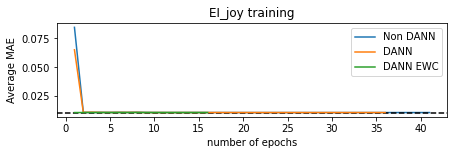

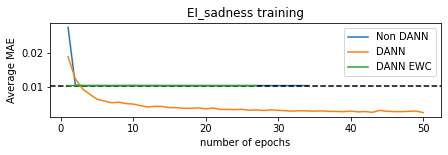

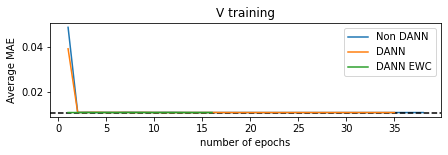

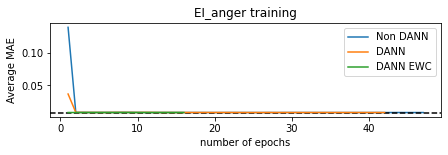

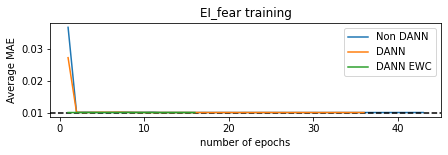

In [56]:
# Training Loss plots

for index, name in enumerate(list_name):
  fig=plt.figure(figsize=(7,10))
  fig.add_subplot(5, 1, index+1)
  list1_to_plot= dict_non_dann_losses_list [name]['train_losses']
  plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.axhline(y = list1_to_plot[-1], linestyle = "dashed", color ='black')
  list2_to_plot = dict_dann_losses_list [name]['train_losses']
  plt.plot(range(1,len(list2_to_plot)+1),list2_to_plot, label =  'DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  list3_to_plot = dict_dann_ewc_losses_list [name]['train_losses']
  plt.plot(range(1,len(list3_to_plot)+1),list3_to_plot, label =  'DANN EWC')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.legend()
  plt.title(name + " training")
  plt.show()



In [57]:
len(range(50,101))

51

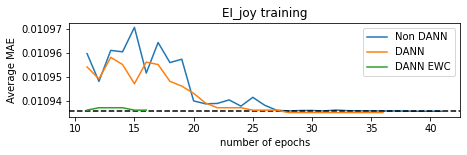

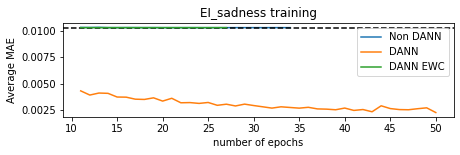

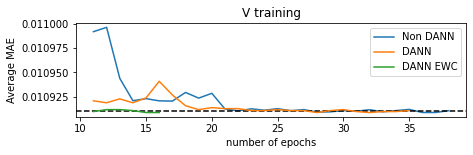

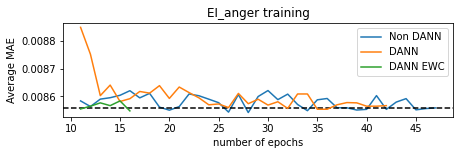

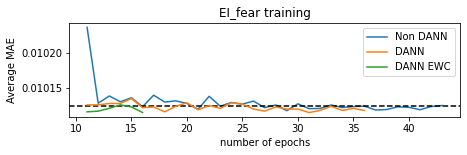

In [58]:
# Training Loss plots x onwards
x = 10

for index, name in enumerate(list_name):
  fig=plt.figure(figsize=(7,10))
  fig.add_subplot(5, 1, index+1)
  list1_to_plot= dict_non_dann_losses_list [name]['train_losses']
  plt.plot(range(x+1,len(list1_to_plot)+1),list1_to_plot[x:], label = 'Non DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.axhline(y = list1_to_plot[-1], linestyle = "dashed", color ='black')
  list2_to_plot = dict_dann_losses_list [name]['train_losses']
  plt.plot(range(x+1,len(list2_to_plot)+1),list2_to_plot[x:], label =  'DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  list3_to_plot = dict_dann_ewc_losses_list [name]['train_losses']
  plt.plot(range(x+1,len(list3_to_plot)+1),list3_to_plot[x:], label =  'DANN EWC')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.legend()
  plt.title(name + " training")
  plt.show()



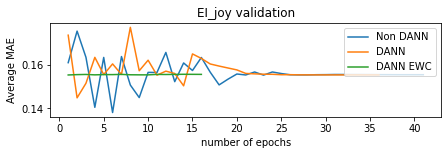

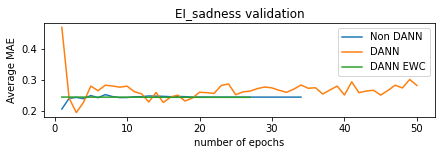

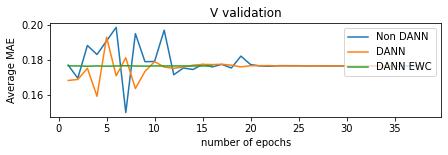

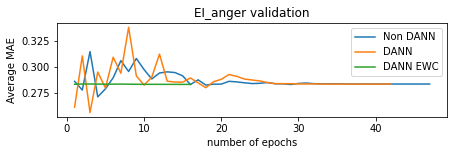

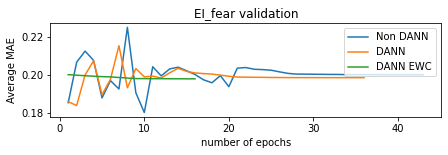

In [59]:
# Validation Loss plots

for index, name in enumerate(list_name):
  fig=plt.figure(figsize=(7,10))
  fig.add_subplot(5, 1, index+1)
  list1_to_plot= dict_non_dann_losses_list [name]['val_losses']
  plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  list2_to_plot = dict_dann_losses_list [name]['val_losses']
  plt.plot(range(1,len(list2_to_plot)+1),list2_to_plot, label =  'DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  list3_to_plot = dict_dann_ewc_losses_list [name]['val_losses']
  plt.plot(range(1,len(list3_to_plot)+1),list3_to_plot, label =  'DANN EWC')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.legend(loc = 'upper right')
  plt.title(name +" validation")

  plt.show()


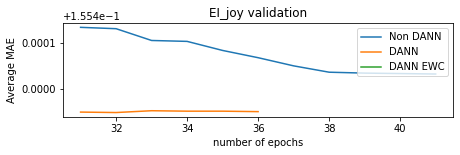

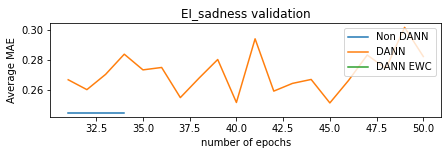

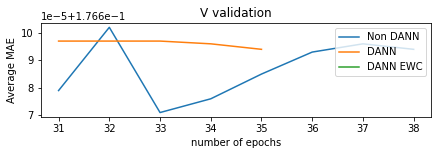

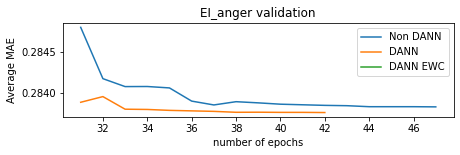

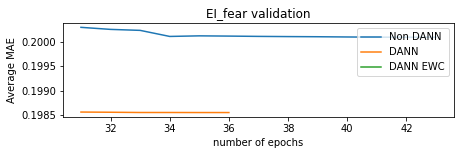

In [60]:
# Validation Loss plots after x
x = 30

for index, name in enumerate(list_name):
  fig=plt.figure(figsize=(7,10))
  fig.add_subplot(5, 1, index+1)
  list1_to_plot= dict_non_dann_losses_list [name]['val_losses']
  plt.plot(range(x+1,len(list1_to_plot)+1),list1_to_plot[x:], label = 'Non DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  list2_to_plot = dict_dann_losses_list [name]['val_losses']
  plt.plot(range(x+1,len(list2_to_plot)+1),list2_to_plot[x:], label =  'DANN')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  list3_to_plot = dict_dann_ewc_losses_list [name]['val_losses']
  plt.plot(range(x+1,len(list3_to_plot)+1),list3_to_plot[x:], label =  'DANN EWC')
  plt.xlabel('number of epochs', fontsize=10)
  plt.ylabel('Average MAE', fontsize=10)
  plt.legend(loc = 'upper right')
  plt.title(name +" validation")

  plt.show()

# Equality Evaluation using Equity Evaluation Corpus

## Loading Evaluation Data
format `[ID	Sentence	Template	Person	Gender	Race Emotion	Emotion word]`

In [61]:
data_EEC = TASK1.EEC['eec']
df_EEC = pd.read_csv(data_EEC)
df_EEC.head()

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry
1,2018-En-mystery-11722,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious
2,2018-En-mystery-11364,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated
3,2018-En-mystery-14320,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged
4,2018-En-mystery-14114,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed


## Creating evalution function (includes pre-processing)

In [62]:
## padding function : adds padding / truncates to max size
def pad_or_truncate(some_list, target_len = MAX_SIZE, pad_idx = PAD_IDX):
    return some_list[:target_len] + [pad_idx]*(target_len - len(some_list))

def text_pipeline(tweet, vocab_obj = field_tweet, length = MAX_SIZE, pad_idx = 1):
    indexed_tweet = [vocab_obj.vocab.__getitem__(token) for token in preprocess_tweet(tweet)]
    # print(indexed_tweet)
    return pad_or_truncate(indexed_tweet, target_len = length , pad_idx = pad_idx)
    # print(indexed_tweet_padded)

## Loading model

In [63]:
dict_non_dann_model_saved ={}
dict_dann_model_saved ={}
dict_dann_ewc_model_saved ={}
for name, _ in dict_model_arch.items():
  dict_non_dann_model_saved[name] = name +"_" +str(time.strftime("%d_%m"))+ "_non_dann_"+EMBEDDING_TO_BE_USED+".pt"
  dict_dann_model_saved[name] = name +"_" +str(time.strftime("%d_%m"))+ "_dann_"+EMBEDDING_TO_BE_USED+".pt"  
  dict_dann_ewc_model_saved[name] = name + "_" + str(time.strftime("%d_%m")) + "_dann_ewc_"+EMBEDDING_TO_BE_USED+".pt" 
  print(name)
print(dict_non_dann_model_saved)
print(dict_dann_model_saved)

EI_joy
EI_sadness
V
EI_anger
EI_fear
{'EI_joy': 'EI_joy_25_01_non_dann_glove_gn.pt', 'EI_sadness': 'EI_sadness_25_01_non_dann_glove_gn.pt', 'V': 'V_25_01_non_dann_glove_gn.pt', 'EI_anger': 'EI_anger_25_01_non_dann_glove_gn.pt', 'EI_fear': 'EI_fear_25_01_non_dann_glove_gn.pt'}
{'EI_joy': 'EI_joy_25_01_dann_glove_gn.pt', 'EI_sadness': 'EI_sadness_25_01_dann_glove_gn.pt', 'V': 'V_25_01_dann_glove_gn.pt', 'EI_anger': 'EI_anger_25_01_dann_glove_gn.pt', 'EI_fear': 'EI_fear_25_01_dann_glove_gn.pt'}


In [64]:
### Loading Model


# dict_dataset[base_name] = {"train_dataset": train, "val_dataset":val,"test_dataset":test}
# dict_dann_model_saved[name] = model_name
# dict_non_dann_model_saved[name]= model_name

dict_loaded_models = {}
for name in list_name:
  non_dann_model_name = dict_non_dann_model_saved[name]
  dann_model_name = dict_dann_model_saved[name]
  dann_ewc_model_name = dict_dann_ewc_model_saved[name]
  # print(non_dann_model_name,dann_model_name)
  
  INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
  print(name, INPUT_DIM)
  PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]

  loaded_model_non_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_non_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, non_dann_model_name),map_location=torch.device(DEVICE)))
  loaded_model_non_dann.eval()

  loaded_model_dann = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_dann.load_state_dict(torch.load(os.path.join(MODEL_DIR, dann_model_name),map_location=torch.device(DEVICE)))
  loaded_model_dann.eval()

  loaded_model_dann_ewc = CNN1d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
  loaded_model_dann_ewc.load_state_dict(torch.load(os.path.join(MODEL_DIR, dann_ewc_model_name),map_location=torch.device(DEVICE)))
  loaded_model_dann_ewc.eval()

  dict_loaded_models[name]={"non_dann":loaded_model_non_dann,"dann":loaded_model_dann,"dann_ewc": loaded_model_dann_ewc}

print(dict_loaded_models.keys())

EI_joy 4653
EI_sadness 4859
V 4320
EI_anger 4689
EI_fear 5544
dict_keys(['EI_joy', 'EI_sadness', 'V', 'EI_anger', 'EI_fear'])


In [65]:
from torch.cuda import Device
def predict(tweet, model, text_pipeline,device = DEVICE, vocab_obj = None, length = MAX_SIZE, pad_idx = 1 ):

  with torch.no_grad():
    # tweet_tensor = torch.tensor(text_pipeline(tweet)).unsqueeze(0).to(device)
    tweet_tensor = torch.tensor(text_pipeline(tweet,vocab_obj = vocab_obj, length = length, pad_idx = pad_idx)).unsqueeze(0).to(device)
    output = model(tweet_tensor)
    return output[0].item()

In [66]:
# i = random.randint(0,len(df_EEC))
# tweet_example = df_EEC['Sentence'][i]
# loaded_model_device = 'cpu'
# loaded_model = dict_loaded_models['EI_anger']['dann'].to(loaded_model_device)
# print(predict(tweet_example, loaded_model,text_pipeline, device= loaded_model_device))

## Creating Sentence pairs (as per SEMVAL18 paper)

In [67]:
dict_f_m_noun_phrase = {'she':'he', 
            'her':'him',
            'this woman':'this man',
            'this girl':'this boy',
            'my sister' : 'my brother',
            'my daughter' : 'my son',
            'my wife': 'my husband',
            'my girlfriend':'my boyfriend',
            'my mother':'my father',
            'my aunt':'my uncle',
            'my mom': 'my dad'
            }

name_male = ['Alonzo','Jamel','Alphonse','Jerome','Leroy','Torrance','Darnell','Lamar','Malik','Terrence','Adam','Harry','Josh','Roger','Alan','Frank','Justin','Ryan','Andrew','Jack'] 
name_female = ['Nichelle','Shereen','Ebony','Latisha','Shaniqua','Jasmine','Tanisha','Tia','Lakisha','Latoya','Amanda','Courtney','Heather','Melanie','Katie','Betsy','Kristin','Nancy','Stephanie','Ellen']


In [68]:
list_unique_template = list(df_EEC['Template'].dropna().unique())
# print(list_unique_template)
list_emotion_word = list(df_EEC['Emotion word'].unique()) # contains nan also
# print(list_emotion_word)
list_gender = list(df_EEC['Gender'].dropna().unique())
# print(list_gender)
list_person = list(df_EEC['Person'].unique())   
# print(list_person)

In [69]:
# print(list_emotion_word) # nan exists in the emotion word list

In [70]:
# Template - F - M Noun Phrases chunks (Checked again 3012)

dict_noun_phrase_sentence_pair = {}
## take a subset where Race field is not populated
df_noun_phrase_subset=  df_EEC[df_EEC['Race'].isna()] ## includes values which do not have Race 
count = 0
# print(len(df_noun_phrase_subset),df_noun_phrase_subset.head())
for template in list_unique_template:
  for emotion_word in list_emotion_word:
    condition_1 = (df_noun_phrase_subset['Template']== template)
    condition_2 = (df_noun_phrase_subset['Emotion word'] == emotion_word)
    condition_3 = (df_noun_phrase_subset['Gender'] == 'female')
    condition_4 = (df_noun_phrase_subset['Gender'] == 'male')
    list_female = df_noun_phrase_subset[(condition_1) & (condition_2) & (condition_3)]['Sentence'].to_list()
    list_male = df_noun_phrase_subset[(condition_1) & (condition_2) & (condition_4)]['Sentence'].to_list()
    if ((len(list_female) >0) & (len(list_male) >0)):
      dict_noun_phrase_sentence_pair[count]=(list_female,list_male)
      # print(emotion_word, "emotion word")
      count = count + 1
    
    if pd.isnull(emotion_word):
      condition_5 = (df_noun_phrase_subset['Emotion word'].isna())
      list_female_2 = df_noun_phrase_subset[(condition_5) & (condition_1) & (condition_3)]['Sentence'].to_list()
      list_male_2 = df_noun_phrase_subset[(condition_5) & (condition_1) & (condition_4)]['Sentence'].to_list()
      if ((len(list_female_2) >0) & (len(list_male_2) >0)):
        dict_noun_phrase_sentence_pair[count]=(list_female_2,list_male_2)
        # print("no emotion word")
        count = count + 1

print(count)
# print(len(dict_noun_phrase_sentence_pair),"dict_noun_phrase_sentence_pair............ \n",dict_noun_phrase_sentence_pair)                                                                                                                                                                                                                                         


144


In [71]:
# Template -  ORIGINAL TRYING 3012

dict_original_sentence_pair = {}
count = 0

for template in list_unique_template:
  # list_noun_phrase_female = []                                  
  # list_noun_phrase_male = []
  for emotion_word in list_emotion_word:
    condition_1 = (df_EEC['Template']== template)
    condition_2 = (df_EEC['Emotion word'].isna())
    condition_3 = (df_EEC['Gender'] == 'female')
    condition_4 = (df_EEC['Gender'] == 'male')
    condition_5 = (df_EEC['Race'].notnull())
    condition_6 = (df_EEC['Race'].isna())
    condition_9 = (df_EEC['Emotion word'].notnull())
    list_noun_phrase_female = []
    list_noun_phrase_male = []
    if pd.isnull(emotion_word):
      
      # Check for named people - no emotion
      list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_5)]['Sentence'].to_list()
      list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_5)]['Sentence'].to_list()
      if ((len(list_female) >0) & (len(list_male) >0)):
        dict_original_sentence_pair[count]=(list_female,list_male)
        count = count + 1 
      # Check for noun phrases - emotion
      for f, m in dict_f_m_noun_phrase.items():
        condition_7 = df_EEC['Person']== f
        condition_8 = df_EEC['Person']== m
        list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_6) & (condition_7)]['Sentence'].to_list()
        list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_6) & (condition_8)]['Sentence'].to_list()
        if ((len(list_female) >0) & (len(list_male) >0)):
          list_noun_phrase_female.append(list_female[0])
          list_noun_phrase_male.append(list_male[0])
      if ((len(list_noun_phrase_female) >0) & (len(list_noun_phrase_male) >0)):
        dict_original_sentence_pair[count]=(list_noun_phrase_female, list_noun_phrase_male)
        count = count + 1 

    else: # emotion is present
      # Check for named people - with emotion
      list_female = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_3) & (condition_5)]['Sentence'].to_list()
      list_male = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_4) & (condition_5)]['Sentence'].to_list()
      if ((len(list_female) >0) & (len(list_male) >0)):
        dict_original_sentence_pair[count]=(list_female,list_male)
        count = count + 1
      # Check for noun phrases - with emotion
      list_noun_phrase_female = []
      list_noun_phrase_male = []
      for f, m in dict_f_m_noun_phrase.items():
        condition_7 = df_EEC['Person']== f
        condition_8 = df_EEC['Person']== m
        list_female = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_3) & (condition_6) & (condition_7)]['Sentence'].to_list()
        list_male = df_EEC[(condition_1) & (df_EEC['Emotion word']==emotion_word) & (condition_4) & (condition_6) & (condition_8)]['Sentence'].to_list()
        if ((len(list_female) >0) & (len(list_male) >0)):
          list_noun_phrase_female.append(list_female[0])
          list_noun_phrase_male.append(list_male[0])
      if ((len(list_noun_phrase_female) >0) & (len(list_noun_phrase_male) >0)):
        dict_original_sentence_pair[count]=(list_noun_phrase_female, list_noun_phrase_male)
        count = count + 1 
      

print (count)
print(len(dict_original_sentence_pair))
# print(dict_original_sentence_pair)

      
# print(len(dict_original_sentence_pair),"dict_original_sentence_pair............ \n",dict_original_sentence_pair)

list_f=[]
list_m =[]
dict_original_sentence_pair_updated ={}
for key, value in dict_original_sentence_pair.items():
  list_f = list_f + value[0]
  list_m = list_m + value[1]
  # list_f.append(value[0])
  # list_m.append(value[1])

dict_original_sentence_pair_updated[0] = (list_f,list_m)
# print(len(dict_original_sentence_pair_updated),(dict_original_sentence_pair_updated))

288
288


In [72]:
# for Named people (Checked again 3012)

dict_list_named_sentence_pairs ={}
df_EEC_subset = df_EEC.dropna(subset = ['Race']) ## removes values which do not have Race 
print(len(df_EEC_subset))

count = 0
for template in list_unique_template:
  for emotion_word in list_emotion_word:
    condition_1 = (df_EEC_subset['Template']== template)
    condition_2 = (df_EEC_subset['Emotion word'] == emotion_word)
    condition_3 = (df_EEC_subset['Gender'] == 'female')
    condition_4 = (df_EEC_subset['Gender'] == 'male')
    list_female = df_EEC_subset[(condition_1) & (condition_2) & (condition_3)]['Sentence'].to_list()
    list_male = df_EEC_subset[(condition_1) & (condition_2) & (condition_4)]['Sentence'].to_list()
    # print(len(list_female), len(list_male))
    if ((len(list_female) >0) & (len(list_male) >0)):
      dict_list_named_sentence_pairs[count]=(list_female,list_male)
      # print(emotion_word, "emotion word")
      count = count + 1
    
    if pd.isnull(emotion_word):
      condition_5 = (df_EEC_subset['Emotion word'].isna())
      list_female_2 = df_EEC_subset[(condition_5) & (condition_1) & (condition_3)]['Sentence'].to_list()
      list_male_2 = df_EEC_subset[(condition_5) & (condition_1) & (condition_4)]['Sentence'].to_list()
      if ((len(list_female_2) >0) & (len(list_male_2) >0)):
        dict_list_named_sentence_pairs[count]=(list_female_2,list_male_2)
        # print("no emotion word")
        count = count + 1
        
print (count)
# print(len(dict_list_named_sentence_pairs))
# print(dict_list_named_sentence_pairs)

5760
144


In [73]:
# for no emotion people (Checked again 3012)

dict_no_emotion_sentence_pairs ={}
count = 0


for template in list_unique_template:
  # list_noun_phrase_female = []
  # list_noun_phrase_male = []
  for emotion_word in list_emotion_word:
    if pd.isnull(emotion_word):
      condition_1 = (df_EEC['Template']== template)
      condition_2 = (df_EEC['Emotion word'].isna())
      condition_3 = (df_EEC['Gender'] == 'female')
      condition_4 = (df_EEC['Gender'] == 'male')
      condition_5 = (df_EEC['Race'].notnull())
      condition_6 = (df_EEC['Race'].isna())

      # Check for named people
      list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_5)]['Sentence'].to_list()
      list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_5)]['Sentence'].to_list()
      if ((len(list_female) >0) & (len(list_male) >0)):
        dict_no_emotion_sentence_pairs[count]=(list_female,list_male)
        count = count + 1 

      # Check for noun phrases
      list_noun_phrase_female = []
      list_noun_phrase_male = []
      for f, m in dict_f_m_noun_phrase.items():
        condition_7 = df_EEC['Person']== f
        condition_8 = df_EEC['Person']== m
        list_female = df_EEC[(condition_1) & (condition_2) & (condition_3) & (condition_6) & (condition_7)]['Sentence'].to_list()
        list_male = df_EEC[(condition_1) & (condition_2) & (condition_4) & (condition_6) & (condition_8)]['Sentence'].to_list()
        if ((len(list_female) >0) & (len(list_male) >0)):
          list_noun_phrase_female.append(list_female[0])
          list_noun_phrase_male.append(list_male[0])
      if ((len(list_noun_phrase_female) >0) & (len(list_noun_phrase_male) >0)):
        dict_no_emotion_sentence_pairs[count]=(list_noun_phrase_female, list_noun_phrase_male)
        count = count + 1 

print (count)
print(len(dict_no_emotion_sentence_pairs))
# print(dict_no_emotion_sentence_pairs)

8
8


In [74]:
## No EMOTION 1 sentence pair

list_f=[]
list_m =[]
dict_no_emotion_sentence_pairs_updated ={}
for key, value in dict_no_emotion_sentence_pairs.items():
  list_f = list_f + value[0]
  list_m = list_m + value[1]


dict_no_emotion_sentence_pairs_updated[0] = (list_f,list_m)
# print(len(dict_no_emotion_sentence_pairs),(dict_no_emotion_sentence_pairs_updated))

In [75]:
# print(dict_list_named_sentence_pairs[0][0],"\n",dict_list_named_sentence_pairs[0][1])

In [76]:
# ANGER ONLY, SADNESS ONLY, FEAR ONLY, JOY ONLY 1 Sentence pair

dict_emotion_sentence_pairs ={}


for emotion in df_EEC['Emotion'].dropna().unique().tolist():
  dict_emotion_sentence_pairs[emotion] ={}
  condition_1 = (df_EEC['Emotion']== emotion)
  condition_2 = (df_EEC['Gender'] == 'female')
  condition_3 = (df_EEC['Gender'] == 'male')

  list_female = df_EEC[(condition_1) & (condition_2)]['Sentence'].to_list()
  list_male = df_EEC[(condition_1) & (condition_3)]['Sentence'].to_list()
  dict_emotion_sentence_pairs[emotion][0]=(list_female,list_male)


print(dict_emotion_sentence_pairs.keys())

dict_keys(['anger', 'sadness', 'fear', 'joy'])


## Two Sample t- test

In [77]:
# f ='She feels angry.'
# m ='He feels angry.'
# f_indices = text_pipeline(f)
# m_indices = text_pipeline(m)
# f_value = predict(f, loaded_model,text_pipeline,device= loaded_model_device)
# m_value = predict(m, loaded_model,text_pipeline,device= loaded_model_device)
# print(f_value,m_value)
# stats.ttest_rel(f_value, m_value)

In [78]:
# Function for t-test processing

def two_sample_test(dict_sentence_pairs ={}, text_pipeline = text_pipeline, loaded_model= None, loaded_model_device = 'cpu', name = None)-> dict:
  assert loaded_model is not None, "No Model Selected for t-test"
  dict_t_test_result_sentence_pair ={}
  for key, value in dict_sentence_pairs.items():

    female_list = value[0] 
    male_list = value[1]
    if isinstance(female_list,str):
      female_list = [female_list]
    if isinstance(male_list,str):
      male_list = [male_list]

    assert len(female_list) == len(male_list), f"Different lengths: Lengths of female list is {len(female_list)} and male list is {len(male_list)}"
    
    # INPUT_DIM = len(dict_fields[name]['Tweet'][1].vocab)
    PAD_IDX = dict_fields[name]['Tweet'][1].vocab.stoi[dict_fields[name]['Tweet'][1].pad_token]


    female_list_indices = [text_pipeline(tweet_example,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX) for tweet_example in female_list]
    male_list_indices = [text_pipeline(tweet_example,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX) for tweet_example in male_list]

    # print(female_list_indices)
    # print("type check for all elements ",all(isinstance(x, (int, float)) for x in female_list_indices))
    # print("length ",len(set(female_list_indices)))

    # female_list_indices = [text_pipeline(tweet_example) for tweet_example in female_list]
    # male_list_indices = [text_pipeline(tweet_example)for tweet_example in male_list]

    female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX ) for sentence in female_list]
    male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device,vocab_obj = dict_fields[name]['Tweet'][1], length = MAX_SIZE, pad_idx = PAD_IDX) for sentence in male_list]
    # female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in female_list]
    # male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in male_list]

    # print(female_list_output)
    # print("type check for all elements ",all(isinstance(x, (int, float)) for x in female_list_output))
    # print("length ",len(set(female_list_output)))

    t_test_result = stats.ttest_rel(female_list_output, male_list_output)
    dict_t_test_result_sentence_pair[key] = (t_test_result.statistic, t_test_result.pvalue,mean(female_list_output)-mean(male_list_output))
  # print(dict_t_test_result_sentence_pair)
  return dict_t_test_result_sentence_pair



In [79]:
dict_loaded_models.keys()

dict_keys(['EI_joy', 'EI_sadness', 'V', 'EI_anger', 'EI_fear'])

In [80]:
# type(dict_emotion_sentence_pairs['joy'].values())
for name, value in dict_emotion_sentence_pairs['joy'].items():
  print (len(value[0]),len(value[1]) )
  # print( value[0])


1050 1050


In [81]:
lm = dict_loaded_models['EI_joy']['dann_ewc']

In [82]:
t_test_level_2 = two_sample_test(dict_sentence_pairs = dict_emotion_sentence_pairs['joy'] ,
                                 text_pipeline = text_pipeline, 
                                 loaded_model = lm, 
                                 loaded_model_device = 'cpu',
                                 name = 'EI_joy')
# t_test_level_2

In [83]:
t_test_level_2 = two_sample_test(dict_sentence_pairs = dict_no_emotion_sentence_pairs_updated,
                                 text_pipeline = text_pipeline, 
                                 loaded_model = lm, 
                                 loaded_model_device = 'cpu',
                                 name = 'EI_joy')
# t_test_level_2

In [84]:
# dict_loaded_models[name]={"non_dann":loaded_model_non_dann,"dann":loaded_model_dann}

# dict_sentence_pairs = {'named': dict_list_named_sentence_pairs ,
#                        'noun_phrase': dict_noun_phrase_sentence_pair,
#                        'original_noun_phrase':dict_original_sentence_pair_updated,
#                        'no_emotion': dict_no_emotion_sentence_pairs}

dict_sentence_pairs = {
    # 'named': dict_list_named_sentence_pairs ,
    # 'noun_phrase': dict_noun_phrase_sentence_pair,
    'original_noun_phrase':dict_original_sentence_pair_updated,
    'no_emotion': dict_no_emotion_sentence_pairs_updated,
    'only_anger': dict_emotion_sentence_pairs['anger'],
    'only_sadness' : dict_emotion_sentence_pairs['sadness'],
    'only_fear' : dict_emotion_sentence_pairs['fear'],
    'only_joy' : dict_emotion_sentence_pairs['joy']
                       }

dict_t_test = {}
for name, model_dict in dict_loaded_models.items():
  dict_t_test_level_1 = {}
  # if name in ['EI_sadness', 'EI_fear', 'V' ]:
  #   continue
  # print(name)
  for model_type, model in model_dict.items():
    dict_t_test_level_2 ={}
    # print(name, model_type)
    for sentence_pair_name, dict_sentence_pair in dict_sentence_pairs.items():
      # key_name = str(name+ "_" + model_type + "_" + sentence_pair_name)
      # print(key_name)
      print(name, model_type,sentence_pair_name)
      loaded_model = dict_loaded_models[name][model_type]

      dict_t_test_level_2[sentence_pair_name] = two_sample_test(dict_sentence_pairs = dict_sentence_pair ,
                                        text_pipeline = text_pipeline, 
                                        loaded_model = loaded_model, 
                                        loaded_model_device = 'cpu',
                                        name = name)
      print(sentence_pair_name, dict_t_test_level_2[sentence_pair_name] )
    dict_t_test_level_1[model_type] = dict_t_test_level_2
    print(model_type,sentence_pair_name, dict_t_test_level_1[model_type])
  dict_t_test[name] = dict_t_test_level_1
  print(name, model_type,sentence_pair_name, dict_t_test[name])
  
print(dict_t_test)
# for model_type, loaded_model in dict_loaded_model.items():
#   dict_t_test[str(model_type)+"_noun_phrase"] = two_sample_test(dict_sentence_pairs =dict_noun_phrase_sentence_pair,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')
#   dict_t_test[str(model_type)+"_named"] = two_sample_test(dict_sentence_pairs =dict_list_named_sentence_pairs,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')


EI_joy non_dann original_noun_phrase
original_noun_phrase {0: (nan, nan, 0.0)}
EI_joy non_dann no_emotion
no_emotion {0: (nan, nan, 0.0)}
EI_joy non_dann only_anger
only_anger {0: (nan, nan, 0.0)}
EI_joy non_dann only_sadness
only_sadness {0: (nan, nan, 0.0)}
EI_joy non_dann only_fear
only_fear {0: (nan, nan, 0.0)}
EI_joy non_dann only_joy
only_joy {0: (nan, nan, 0.0)}
non_dann only_joy {'original_noun_phrase': {0: (nan, nan, 0.0)}, 'no_emotion': {0: (nan, nan, 0.0)}, 'only_anger': {0: (nan, nan, 0.0)}, 'only_sadness': {0: (nan, nan, 0.0)}, 'only_fear': {0: (nan, nan, 0.0)}, 'only_joy': {0: (nan, nan, 0.0)}}
EI_joy dann original_noun_phrase
original_noun_phrase {0: (nan, nan, 0.0)}
EI_joy dann no_emotion
no_emotion {0: (nan, nan, 0.0)}
EI_joy dann only_anger
only_anger {0: (nan, nan, 0.0)}
EI_joy dann only_sadness
only_sadness {0: (nan, nan, 0.0)}
EI_joy dann only_fear
only_fear {0: (nan, nan, 0.0)}
EI_joy dann only_joy
only_joy {0: (nan, nan, 0.0)}
dann only_joy {'original_noun_phrase

In [85]:
# list_sentence_pairs = ['named','noun_phrase']
# dict_t_test ={}
# for model_type, loaded_model in dict_loaded_model.items():
#   dict_t_test[str(model_type)+"_noun_phrase"] = two_sample_test(dict_sentence_pairs =dict_noun_phrase_sentence_pair,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')
#   dict_t_test[str(model_type)+"_named"] = two_sample_test(dict_sentence_pairs =dict_list_named_sentence_pairs,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')


In [86]:
# dict_t_test.items()

In [87]:
# dict_t_test_noun_phrase_sentence_pair = two_sample_test(dict_sentence_pairs =dict_noun_phrase_sentence_pair,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')
# dict_t_test_named_sentence_pairs = two_sample_test(dict_sentence_pairs =dict_list_named_sentence_pairs,text_pipeline = text_pipeline, loaded_model = loaded_model, loaded_model_device = 'cpu')

In [88]:
# dict_result_named_sentence_pair ={}

# for key, value in dict_list_named_sentence_pairs.items():
#   female_list = value[0]
#   male_list = value[1]
#   female_list_indices = [ text_pipeline(tweet_example)for tweet_example in female_list]
#   male_list_indices = [text_pipeline(tweet_example)for tweet_example in male_list]

#   female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in female_list]
#   male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in male_list]
#   # for sentence in female_list:
#   #   female_list_output.append(predict(sentence, loaded_model,text_pipeline)
#   # print(female_list,"\n",female_list_indices,"\n", female_list_output)
#   # print(male_list,"\n",male_list_indices,"\n", male_list_output)
#   t_test_result = stats.ttest_rel(female_list_output, male_list_output)
#   dict_result_named_sentence_pair[key] = (t_test_result.statistic, t_test_result.pvalue,mean(female_list_output)-mean(male_list_output))
#   # print(type(stats.ttest_rel(female_list_output, male_list_output)))

#   # break

# print((dict_result_named_sentence_pair))

In [89]:
# #without named people
# dict_result_sentence_pair ={}
# # for key, value in dict_sentence_pair:
# #   if len(value[0])
# print(len(dict_sentence_pair))

# for key, value in dict_sentence_pair.items():
#   female_list = [value[0]]
#   male_list = [value[1]]
#   # if len(female_list)!=len(male_list):
#   #   print("key:", key)
#   #   print(female_list,"\n",male_list)
#   #   print(len(female_list),"-",len(male_list))
#   #   print(text_pipeline(female_list[0]),"\n",text_pipeline(male_list[0]))
#   #   break

#   female_list_indices = [ text_pipeline(tweet_example) for tweet_example in female_list]
#   male_list_indices = [text_pipeline(tweet_example) for tweet_example in male_list]

#   female_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in female_list]
#   male_list_output = [predict(sentence, loaded_model,text_pipeline,device= loaded_model_device) for sentence in male_list]
#   # for sentence in female_list:
#   #   female_list_output.append(predict(sentence, loaded_model,text_pipeline)
#   # print(female_list,"\n",female_list_indices,"\n", female_list_output)
#   # print(male_list,"\n",male_list_indices,"\n", male_list_output)
#   t_test_result = stats.ttest_rel(female_list_output, male_list_output)
#   dict_result_sentence_pair[key] = (t_test_result.statistic, t_test_result.pvalue,mean(female_list_output)-mean(male_list_output))
#   # print(type(stats.ttest_rel(female_list_output, male_list_output)))

#   # break

# print(dict_result_sentence_pair)

# Analysis of results (based on semval paper)

In [90]:
# dict_t_test_noun_phrase_sentence_pair
# dict_t_test_named_sentence_pairs

In [91]:
# len(dict_t_test_noun_phrase_sentence_pair),len(dict_t_test_named_sentence_pairs)

In [92]:
def analysis_t_test(dict_t_test_sentence_pairs, threshold = 0.05):
  list_output =[]
  for key, test_output in dict_t_test_sentence_pairs.items():
    significant=True
    t_statistic = test_output[0]
    p_value = test_output[1]
    f_m_diff = test_output[2]
    if (float(p_value) > float(threshold) or float(p_value) == float(threshold)):
      significant=False
      category = 'f_equals_m'
    else:
      significant=True
      
      if f_m_diff > 0:
        category='f_high_m_low'
      else:
        category = 'f_low_m_high' 
    list_output.append([key,t_statistic,p_value,significant,f_m_diff,category])
    
  df_columns = ['key','t_statistic','p_value', 'significant','delta','category']
  df_output = pd.DataFrame(list_output, columns = df_columns)


  list_category = list(df_output['category'].unique())
  list_statistics =[]
  for category in list_category:
    df_temp = df_output[df_output['category']==category]
    average = df_temp['delta'].mean()
    # print(category,len(df_temp), average)
    list_statistics.append([category,len(df_temp), average])
  
  # calculating for all starts
  if len(list_statistics) > 1: # All makes sense when there are more than 1 categories
    all_average = df_output['delta'].mean()
    list_statistics.append(["All",len(df_output), all_average])
  # calculating for all ends

  df_statistics = pd.DataFrame(list_statistics, columns = ['category', 'num_pairs','average_difference'])
  return df_statistics


# print(analysis_t_test(dict_t_test_noun_phrase_sentence_pair))
# print(analysis_t_test(dict_t_test_named_sentence_pairs))


In [93]:
{'EI_anger': {
    'non_dann': {
        'original_noun_phrase': {
            0: (0.1998956871564016, 0.8415904073105785, 3.9207107490946136e-05)}}, 
    'dann': {
        'original_noun_phrase': {
            0: (-3.055498578204014, 0.002288182511007486, -0.0005662351846695279)}}}, 'EI_sadness': {'non_dann': {'original_noun_phrase': {0: (0.697356464894513, 0.4856923878774828, 0.0001477275302426695)}}, 'dann': {'original_noun_phrase': {0: (2.6524225900747918, 0.008079505029578445, 0.0012747823571165329)}}}, 'EI_fear': {'non_dann': {'original_noun_phrase': {0: (-1.897698720306802, 0.057935765936073504, -0.0004837316667868352)}}, 'dann': {'original_noun_phrase': {0: (-4.093950892599476, 4.476596480751689e-05, -0.0010545446744395504)}}}, 'EI_joy': {'non_dann': {'original_noun_phrase': {0: (-1.2515370594455935, 0.210942010423521, -0.0002394391637708937)}}, 'dann': {'original_noun_phrase': {0: (-6.649931016376002, 4.1525086430524637e-11, -0.0012206101997030983)}}}, 'V': {'non_dann': {'original_noun_phrase': {0: (-0.6159244491387837, 0.5380417924786083, -0.00019533265795973476)}}, 'dann': {'original_noun_phrase': {0: (-1.5534286604033418, 0.12054065128353071, -0.0005289117702179658)}}}}


{'EI_anger': {'non_dann': {'original_noun_phrase': {0: (0.1998956871564016,
     0.8415904073105785,
     3.9207107490946136e-05)}},
  'dann': {'original_noun_phrase': {0: (-3.055498578204014,
     0.002288182511007486,
     -0.0005662351846695279)}}},
 'EI_sadness': {'non_dann': {'original_noun_phrase': {0: (0.697356464894513,
     0.4856923878774828,
     0.0001477275302426695)}},
  'dann': {'original_noun_phrase': {0: (2.6524225900747918,
     0.008079505029578445,
     0.0012747823571165329)}}},
 'EI_fear': {'non_dann': {'original_noun_phrase': {0: (-1.897698720306802,
     0.057935765936073504,
     -0.0004837316667868352)}},
  'dann': {'original_noun_phrase': {0: (-4.093950892599476,
     4.476596480751689e-05,
     -0.0010545446744395504)}}},
 'EI_joy': {'non_dann': {'original_noun_phrase': {0: (-1.2515370594455935,
     0.210942010423521,
     -0.0002394391637708937)}},
  'dann': {'original_noun_phrase': {0: (-6.649931016376002,
     4.1525086430524637e-11,
     -0.001220610199

In [94]:
dict_statistics={}
for name, dict_model_type_sentence_pair in dict_t_test.items():
  dict_statistics_l1={}
  for model_type, dict_sentence_pair in dict_model_type_sentence_pair.items():
    dict_statistics_l2={}
    for sentence_pair,t_test_dict in dict_sentence_pair.items():
      df_statistics = analysis_t_test(t_test_dict, threshold = 0.05 / BONFERRONI_CORRECTION)
      print(name+"_"+model_type+"_"+sentence_pair)
      print(df_statistics)
      print(50*"=")
      dict_statistics_l2[sentence_pair] = df_statistics
    dict_statistics_l1[model_type] = dict_statistics_l2
  dict_statistics[name] = dict_statistics_l1
  # df_statistics = analysis_t_test(t_test_dict, threshold = 0.05)
  # dict_statistics[model_type_sentence_pair_name] = df_statistics

EI_joy_non_dann_original_noun_phrase
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
EI_joy_non_dann_no_emotion
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
EI_joy_non_dann_only_anger
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
EI_joy_non_dann_only_sadness
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
EI_joy_non_dann_only_fear
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
EI_joy_non_dann_only_joy
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
EI_joy_dann_original_noun_phrase
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
EI_joy_dann_no_emotion
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
EI_joy_dann_only_ange

In [95]:
dict_statistics['EI_joy']['dann_ewc']




{'original_noun_phrase':        category  num_pairs  average_difference
 0  f_low_m_high          1                 0.0,
 'no_emotion':        category  num_pairs  average_difference
 0  f_low_m_high          1                 0.0,
 'only_anger':        category  num_pairs  average_difference
 0  f_low_m_high          1                 0.0,
 'only_sadness':        category  num_pairs  average_difference
 0  f_low_m_high          1                 0.0,
 'only_fear':        category  num_pairs  average_difference
 0  f_low_m_high          1                 0.0,
 'only_joy':        category  num_pairs  average_difference
 0  f_low_m_high          1                 0.0}

In [96]:
col_name = ['name', 'sentence_pair_name', 'model_name', 'results' ]
df_nice_results = pd.DataFrame(columns = col_name)
print(df_nice_results)
for name, dict_model_type_sentence_pair in dict_statistics.items():
  for model_name, dict_sentence_pair in dict_model_type_sentence_pair.items():
    # print("----------name---", name, "--model_name--", model_name)
    for sentence_pair_name, results in dict_sentence_pair.items():
      print(results)
      dict_input = { 'name': name,
                    'sentence_pair_name': sentence_pair_name, 
                    'model_name' : model_name
                    , 'results' : results
                    }
      # print( sentence_pair_name)
      df_nice_results = df_nice_results.append(dict_input, ignore_index=True)
# df_nice_results

Empty DataFrame
Columns: [name, sentence_pair_name, model_name, results]
Index: []
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
       category  num_pairs  average_difference
0  f_low_m_high         

In [97]:
print(df_nice_results.groupby(['name','sentence_pair_name','model_name']))

In [98]:
df_nice_results.to_csv("results.csv")

In [99]:
df_nice_results.sort_values(['sentence_pair_name','name'])

,name,sentence_pair_name,model_name,results
55,EI_anger,no_emotion,non_dann,category num_pairs average_difference...
61,EI_anger,no_emotion,dann,category num_pairs average_difference...
67,EI_anger,no_emotion,dann_ewc,category num_pairs average_difference...
73,EI_fear,no_emotion,non_dann,category num_pairs average_difference...
79,EI_fear,no_emotion,dann,category num_pairs average_difference...
...,...,...,...,...
24,EI_sadness,original_noun_phrase,dann,category num_pairs average_difference 0...
30,EI_sadness,original_noun_phrase,dann_ewc,category num_pairs average_difference...
36,V,original_noun_phrase,non_dann,category num_pairs average_difference...
42,V,original_noun_phrase,dann,category num_pairs average_difference...


# Nice Results

In [100]:
for name in df_nice_results['name'].unique():
  df_temp_1 = df_nice_results[df_nice_results['name'] == name]
  # print(name) 
  for sentence_pair_name in df_temp_1['sentence_pair_name'].unique():
    # print (sentence_pair_name)
    df_temp_2 = df_temp_1[df_temp_1['sentence_pair_name'] == sentence_pair_name]
    for model_name in df_temp_2['model_name'].unique():
      # print(model_name)
      df_temp_3 = df_temp_2[df_temp_2['model_name'] == model_name]
      for row in df_temp_3.iterrows():
        if "only" in sentence_pair_name:
          value_name = name.split("_")[-1]
          value_sentence_pair = sentence_pair_name.split("_")[-1]
          if (value_name == value_sentence_pair):
            print(name+"_"+sentence_pair_name+"_"+model_name + "_"+EMBEDDING_TO_BE_USED)
            print(row[1]['results'])
            print(50*"=")
        else:
          # print(name+"_"+model_name+"_"+sentence_pair_name)
          print(name+"_"+sentence_pair_name+"_"+model_name + "_"+EMBEDDING_TO_BE_USED)
          print(row[1]['results'])
          print(50*"=")
      # # print(name+"_"+model_name+"_"+sentence_pair_name)
      # df_temp_4 = pd.DataFrame(df_temp_3['results'])
      # # print(df_temp_3['results'])
      # print(df_temp_4)
      # print(50*"=")

EI_joy_original_noun_phrase_non_dann_glove_gn
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
EI_joy_original_noun_phrase_dann_glove_gn
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
EI_joy_original_noun_phrase_dann_ewc_glove_gn
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
EI_joy_no_emotion_non_dann_glove_gn
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
EI_joy_no_emotion_dann_glove_gn
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
EI_joy_no_emotion_dann_ewc_glove_gn
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
EI_joy_only_joy_non_dann_glove_gn
       category  num_pairs  average_difference
0  f_low_m_high          1                 0.0
EI_joy_only_joy_dann_glove_gn
       category  num_pairs  average_diff

In [101]:
overall_result = pd.DataFrame()
for sentence_pair_name in df_nice_results['sentence_pair_name'].unique():
    df_temp_1 = df_nice_results[df_nice_results['sentence_pair_name'] == sentence_pair_name]
    if "only" in sentence_pair_name:
        for name in df_nice_results['name'].unique():
            value_name = name.split("_")[-1]
            value_sentence_pair = sentence_pair_name.split("_")[-1]
            if (value_name == value_sentence_pair): 
                df_temp_2 = df_temp_1[df_temp_1['name'] == name]
                print(f'---Like name {value_name} for Like sentence pair {value_sentence_pair}---')
                res = df_temp_2.pivot_table(index = ['sentence_pair_name', 'name'], columns = 'model_name', values ='results', aggfunc ='first').reset_index()
    else:
        res = df_temp_1.pivot_table(index = ['sentence_pair_name', 'name'], columns = 'model_name', values ='results', aggfunc ='first').reset_index()
    overall_result = overall_result.append(res, ignore_index = True)


---Like name anger for Like sentence pair anger---
---Like name sadness for Like sentence pair sadness---
---Like name fear for Like sentence pair fear---
---Like name joy for Like sentence pair joy---


In [102]:
overall_result = overall_result[['sentence_pair_name','name','non_dann','dann','dann_ewc']]
overall_result

model_name,sentence_pair_name,name,non_dann,dann,dann_ewc
0,original_noun_phrase,EI_anger,category num_pairs average_difference...,category num_pairs average_difference...,category num_pairs average_difference...
1,original_noun_phrase,EI_fear,category num_pairs average_difference...,category num_pairs average_difference...,category num_pairs average_difference...
2,original_noun_phrase,EI_joy,category num_pairs average_difference...,category num_pairs average_difference...,category num_pairs average_difference...
3,original_noun_phrase,EI_sadness,category num_pairs average_difference...,category num_pairs average_difference 0...,category num_pairs average_difference...
4,original_noun_phrase,V,category num_pairs average_difference...,category num_pairs average_difference...,category num_pairs average_difference...
5,no_emotion,EI_anger,category num_pairs average_difference...,category num_pairs average_difference...,category num_pairs average_difference...
6,no_emotion,EI_fear,category num_pairs average_difference...,category num_pairs average_difference...,category num_pairs average_difference...
7,no_emotion,EI_joy,category num_pairs average_difference...,category num_pairs average_difference...,category num_pairs average_difference...
8,no_emotion,EI_sadness,category num_pairs average_difference...,category num_pairs average_difference 0...,category num_pairs average_difference...
9,no_emotion,V,category num_pairs average_difference...,category num_pairs average_difference...,category num_pairs average_difference...


In [103]:
file_name = "result_" + EMBEDDING_TO_BE_USED + "_" + str(time.strftime("%d_%m")) + ".csv" 
#name + "_" + str(time.strftime("%d_%m")) + "_dann_ewc_"+EMBEDDING_TO_BE_USED+".pt" 

# overall_result.to_csv("overall_result.csv")
overall_result.to_csv(file_name)

In [104]:
# for sentence_pair_name in df_nice_results['sentence_pair_name'].unique():
#   df_temp_1 = df_nice_results[df_nice_results['sentence_pair_name'] == sentence_pair_name]
#   df_x = df_temp_1.groupby(['name'])
#   df = pd.DataFrame()
#   df = df_x.get_group(name)
#   print(df)
#   results_df = df.set_index(['sentence_pair_name' ,'name','model_name'], drop=True).unstack('model_name')

#   # results_df = df.pivot_table( 'results', ['sentence_pair_name' ,'name'])
#   # results_df = df.pivot_table( 'results',['sentence_pair_name' ,'name'] ,'model_name')
#   print (results_df)
#   # for name in df_nice_results['name'].unique():
#   #   df = pd.DataFrame()
#   #   df = df_x.get_group(name)
#   #   print(type(df))
#   #   print(df)
#   break

  
  # df = pd.DataFrame()
  # df = df_x.first()
  # print(type(df))
  # print(df)
  # # print(df_x)
  # break
  # for name in df_nice_results['name'].unique():
  #   df_temp_2 = df_temp_1[df_temp_1['name'] == name]
  #   print(df_temp_2)
  #   for model_name in df_temp_2['model_name'].unique():
    
  # break